In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import functions
from GP import GP
from GP_grad import GP_grad
import time
import imageio

In [2]:
Noise = True # Specify if noisy or not
Noise_level = 0.1 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

In [3]:
# objective = functions.sin_add(Noise, Noise_level)
objective = functions.Ackley_1(Noise, Noise_level)

bounds = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(bounds) 

f = objective.func
# print(f( np.array([2, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[-4.  4.]]
dim:  1


In [4]:
# max budget for finding good point
Budget = 100
# set seed
seed = 0
# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES']
acquation_function = 'random'

In [5]:
def draw(n_random_draws=3):
    """ samples some points"""
    # np.random.seed(seed) 
    # should draw randomly
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_random_draws, dim))
    return X, f(X)

def get_kernel(lb, ub, sample_size=200):
    np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    gp.optimize()
    gp.fit()
    return gp.get_hyper()

In [6]:
gp = GP_grad(bounds, Noise, Noise_level)
get_kernel(bounds[:, 0], bounds[:, 1], sample_size=50)

{'var': 1.5, 'lengthscale': 0.4003604469931895}

In [7]:
# Xtest -> test points for plotting
n = 500
Xtest = np.linspace(-6, bounds[:, 1], n).reshape(-1, dim)
mu, covar = gp.posterior(Xtest)
s = np.sqrt(np.diag(covar))
mu = np.squeeze(mu)

Kt = gp.cov_RBF(Xtest, Xtest, gp.get_hyper())
K_11 = gp.K11(Xtest)
K_01 = gp.K01(Xtest)

In [8]:
gp.X.shape

(50, 1)

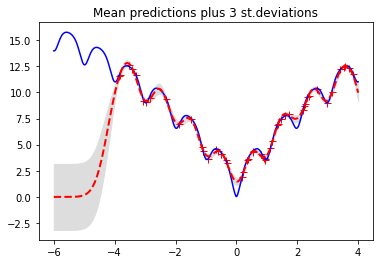

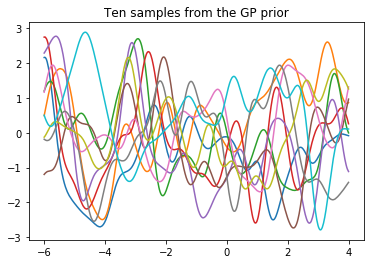

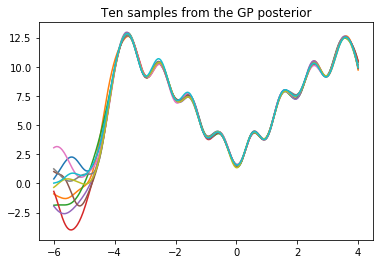

In [9]:
# plot
X = np.squeeze(gp.X)
y = np.squeeze(gp.y)
Xtest = np.squeeze(Xtest)

pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=7)
# pl.plot(Xtest, np.sin(Xtest), 'b-')
pl.plot(Xtest, functions.Ackley_1().func(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")

pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
# pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(Kt + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
# pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
# pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()

In [10]:
mu_grad, covar_grad = gp.posterior_grad(Xtest)
s_grad = np.sqrt(np.diag(covar_grad))
mu_grad = np.squeeze(mu_grad)

In [11]:
# for Ackley 1d, we approximate the gradient here
from scipy import optimize
clean_Ackley_1d = functions.Ackley_1().func
# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = [optimize.approx_fprime(np.array([x]), clean_Ackley_1d, eps) for x in Xtest]

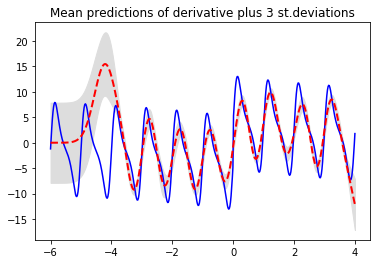

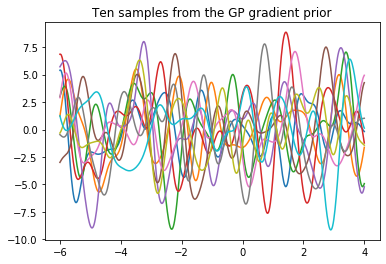

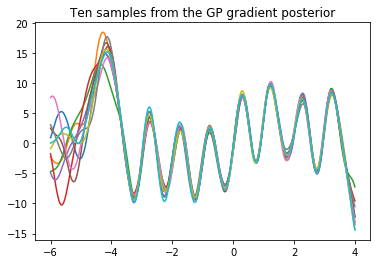

In [12]:
# plot
pl.figure(1)
pl.clf()
# pl.plot(X, y, 'r+', ms=7)
# pl.plot(Xtest, np.cos(Xtest) + 0.1 * np.ones(Xtest.shape), 'b-')
pl.plot(Xtest, approx_grad, 'b-')
pl.gca().fill_between(Xtest.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

pl.plot(Xtest, mu_grad, 'r--', lw=2)
pl.savefig('predictive_grad.png', bbox_inches='tight')
pl.title('Mean predictions of derivative plus 3 st.deviations')
# pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_11 + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP gradient prior')
# pl.axis([-5, 5, -3, 3])
pl.savefig('prior_grad.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar_grad + 1e-6*np.eye(n)) # LL^T = Sigma (posterior covariance)
f_post = mu_grad.reshape(-1,1) + np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP gradient posterior')
# pl.axis([-5, 5, -3, 3])
pl.savefig('post_grad.png', bbox_inches='tight')

pl.show()

### Gradient descent

In [13]:
gp = GP_grad(bounds, Noise, Noise_level)
mesh = np.linspace(-6, bounds[:, 1], 2000).reshape((-1, dim))
np.random.seed(seed)  

X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(4, dim)))
gp.set_data(X, f(X))
gp.fit()
mu, covar = gp.posterior(mesh)


n_iter = 40
lr = 0.1
lr_init = 15
alpha = 0.5

history = []
history_lr = []
w = X[0].reshape(-1, 1)
    
def grad_mean(gp, x): # input a fit gp, find the gradient at x
    assert gp.dim == 1
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))
    return m1.reshape(-1, 1)

def grad_sample(gp, x):
    assert gp.dim == 1
    # partial x1
    gp.set_p(0)
    m1, v1 = gp.posterior_grad(x)
    s1 = np.sqrt(np.diag(v1))
    return np.random.normal(m1.item(), v1.item(), 1).reshape((-1, 1))


grad_mean(gp, w)
# grad_sample(gp, w)

array([[0.9626759]])

In [14]:
# approximated grad on mesh points
approx_grad = [optimize.approx_fprime(np.array([x]), clean_Ackley_1d, eps) for x in mesh]

In [15]:
# for Adam
epsilon = 1e-8
b1 = 0.9
b2 = 0.999
eta = 5e-1
mt = np.array([0])
vt = np.array([0])

`Backtrack`
$$F(x_n + \eta \times d_n) < F(x_n) + \alpha \times \eta \times \langle d_n, \nabla F(x_n)\rangle$$

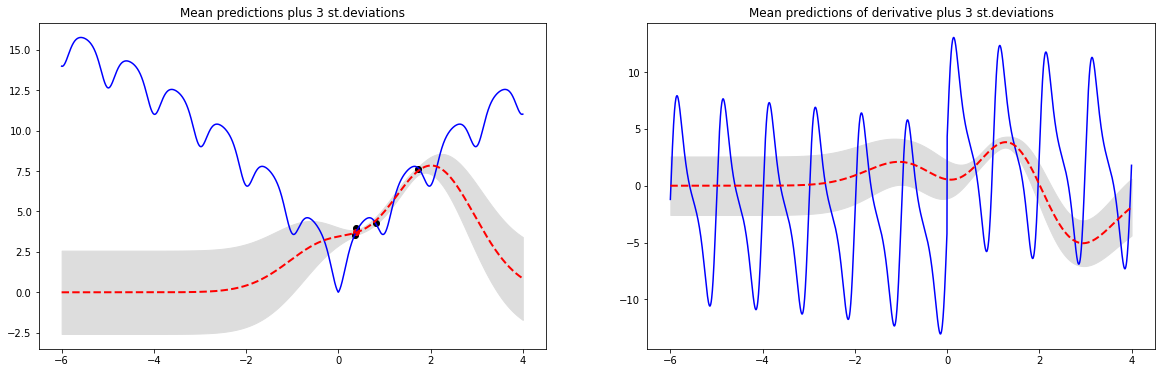

w:  [[-0.10949196]]
lr:  0.1


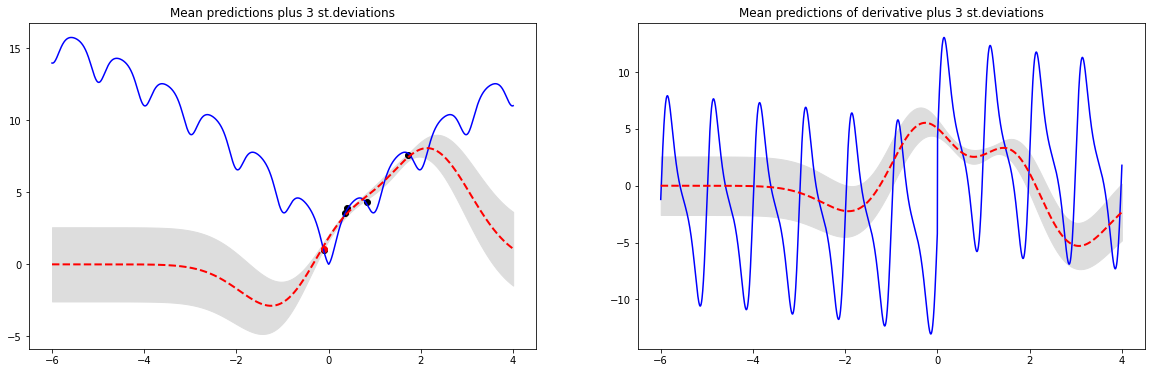

w:  [[-0.53487538]]
lr:  0.1


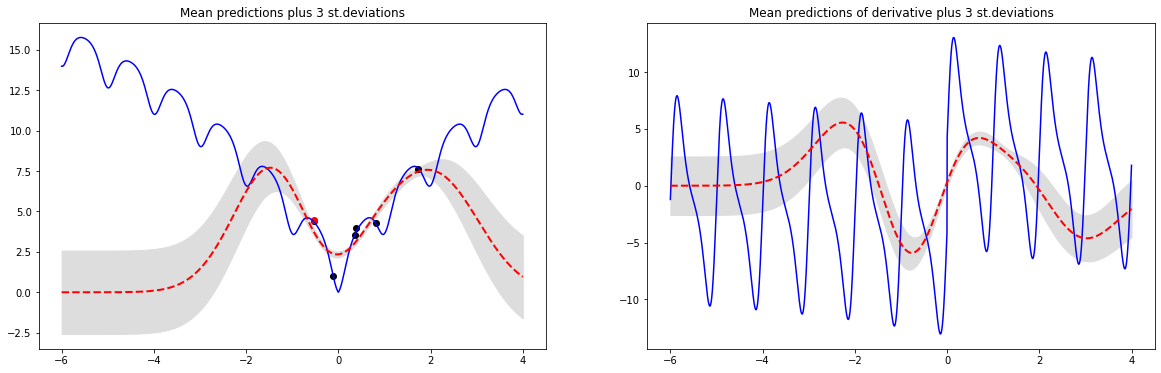

w:  [[-0.55400337]]
lr:  0.1


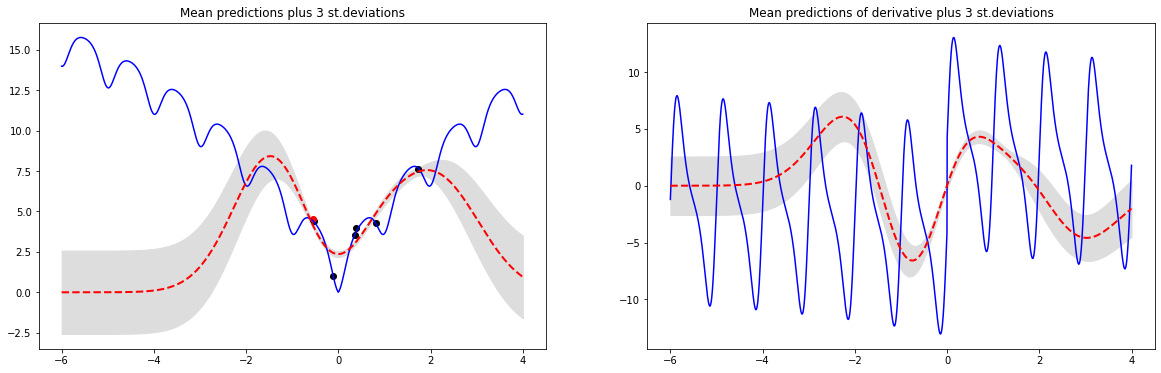

w:  [[-0.38557497]]
lr:  0.1


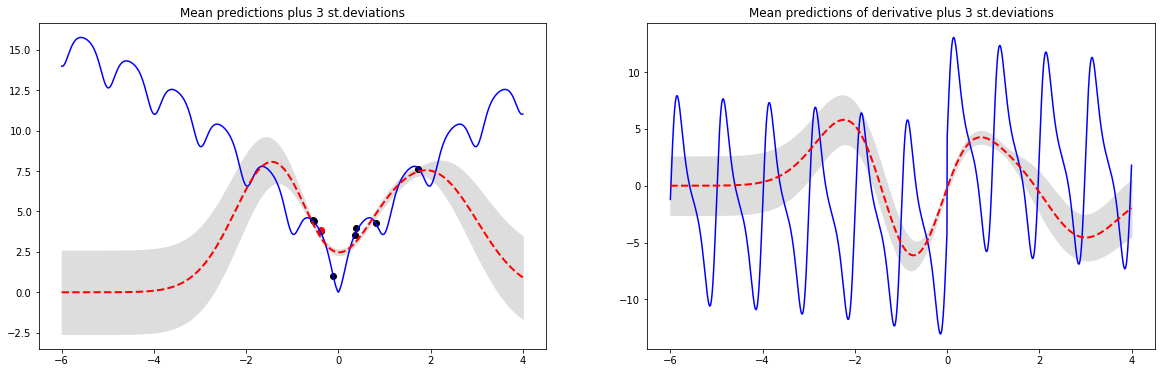

w:  [[-0.14111845]]
lr:  0.1


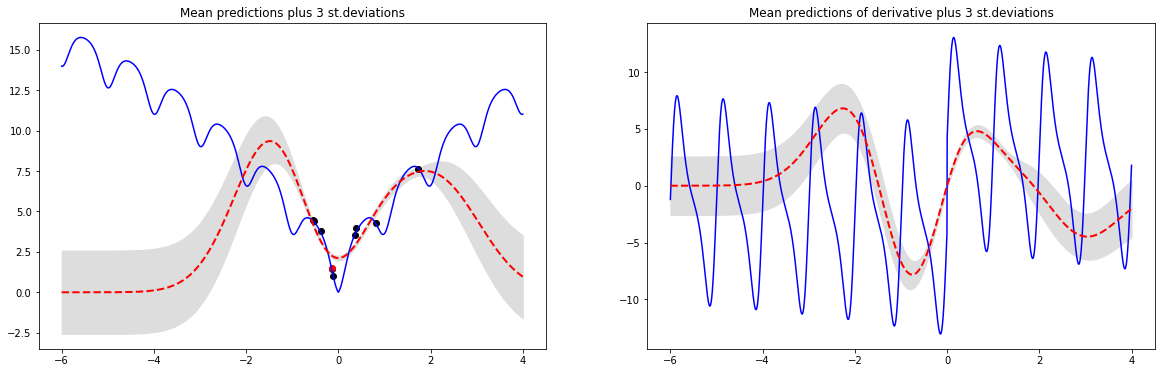

w:  [[0.11536401]]
lr:  0.1


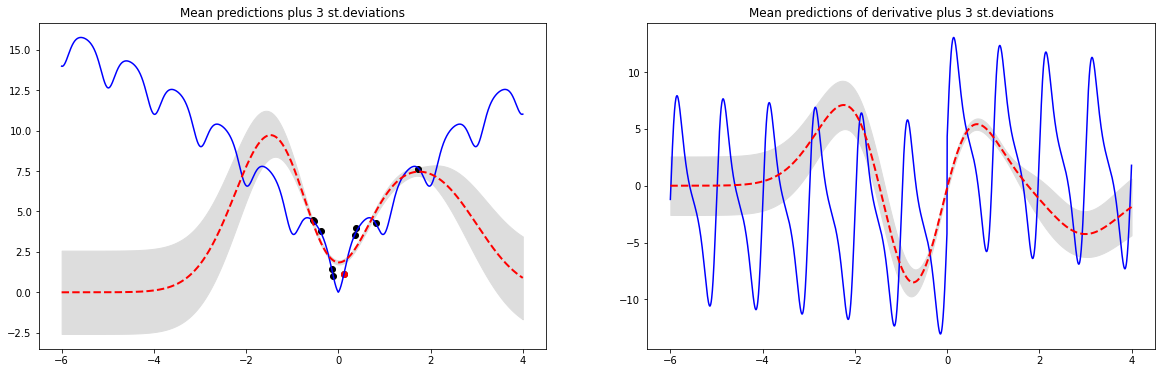

w:  [[0.30156503]]
lr:  0.1


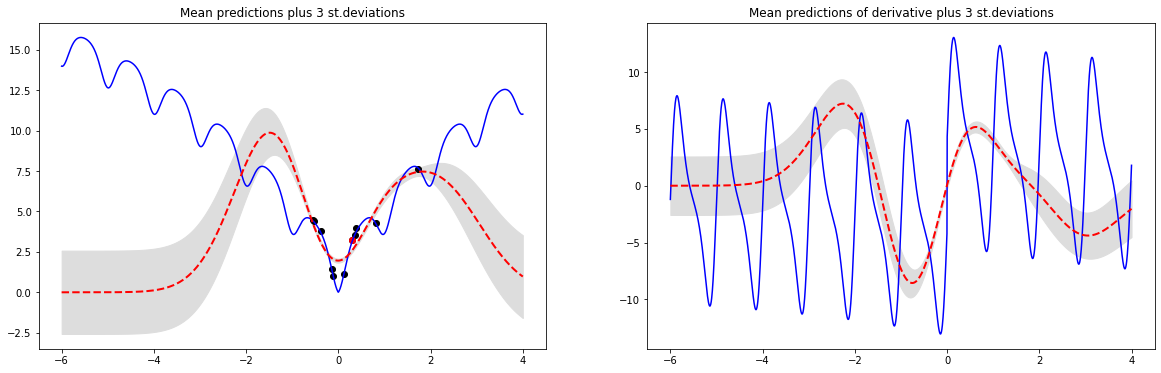

w:  [[0.37424314]]
lr:  0.1


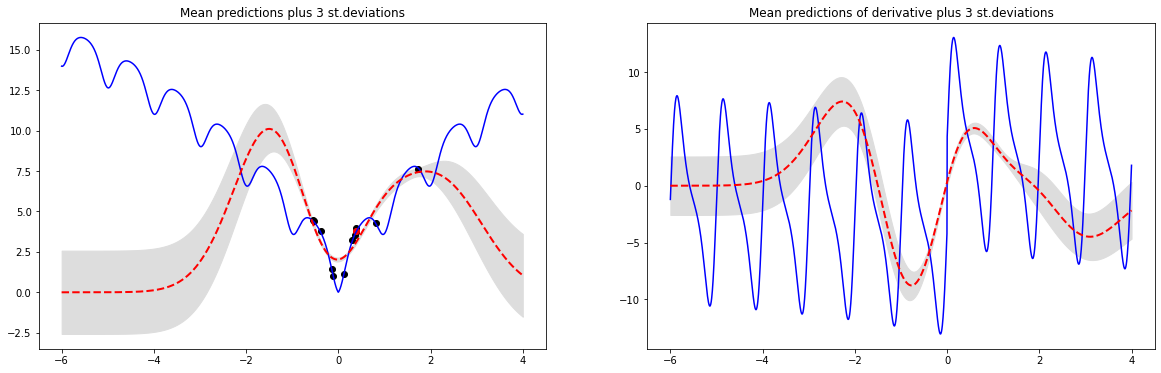

w:  [[0.34576373]]
lr:  0.1


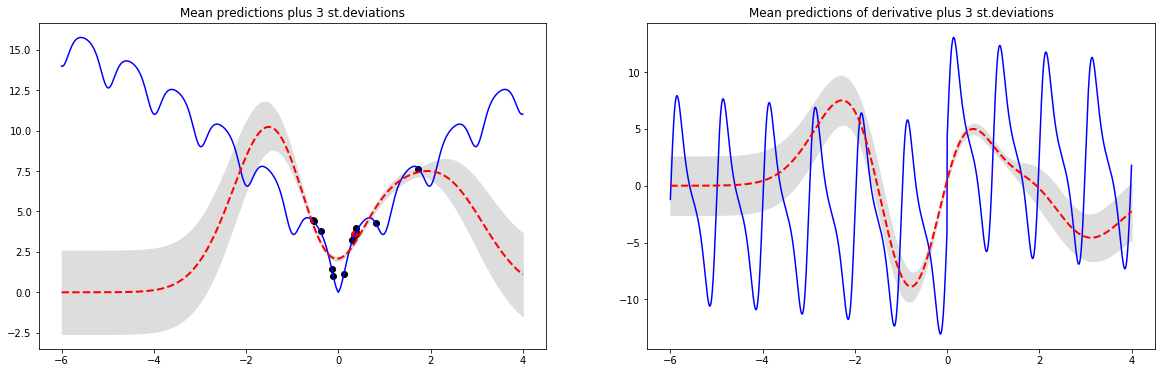

w:  [[0.24142651]]
lr:  0.1


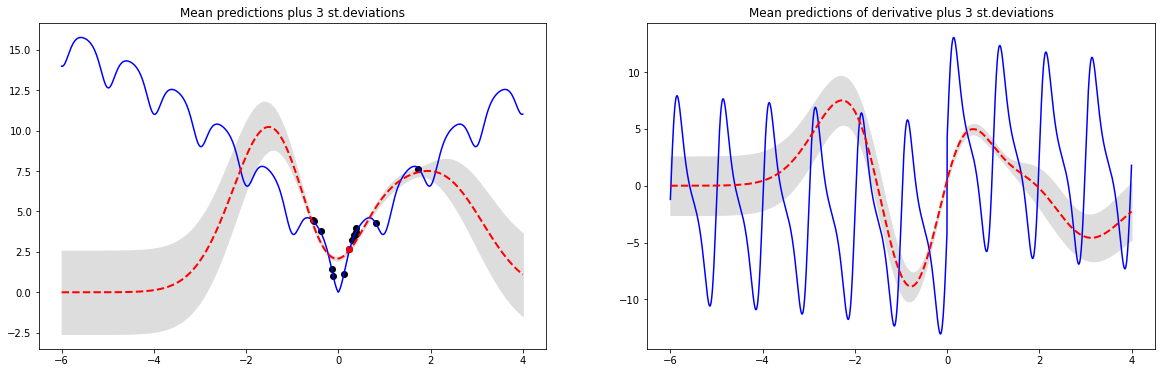

w:  [[0.08838689]]
lr:  0.1


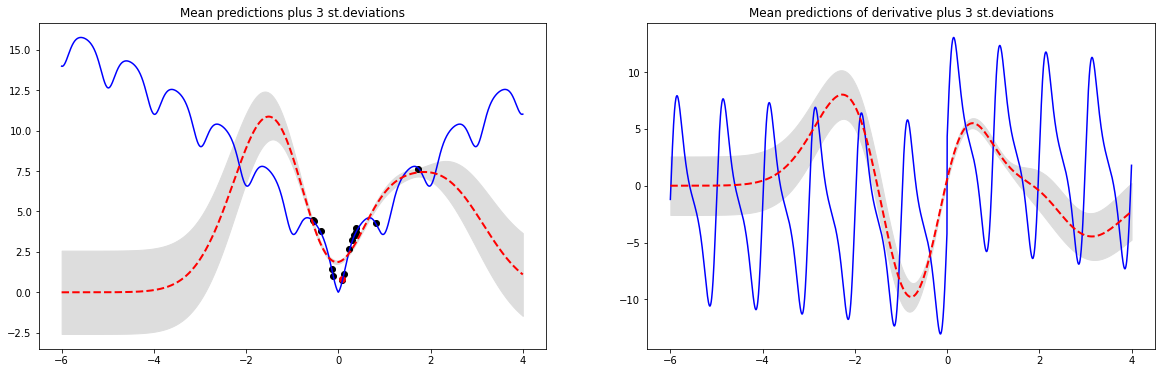

w:  [[-0.08241581]]
lr:  0.1


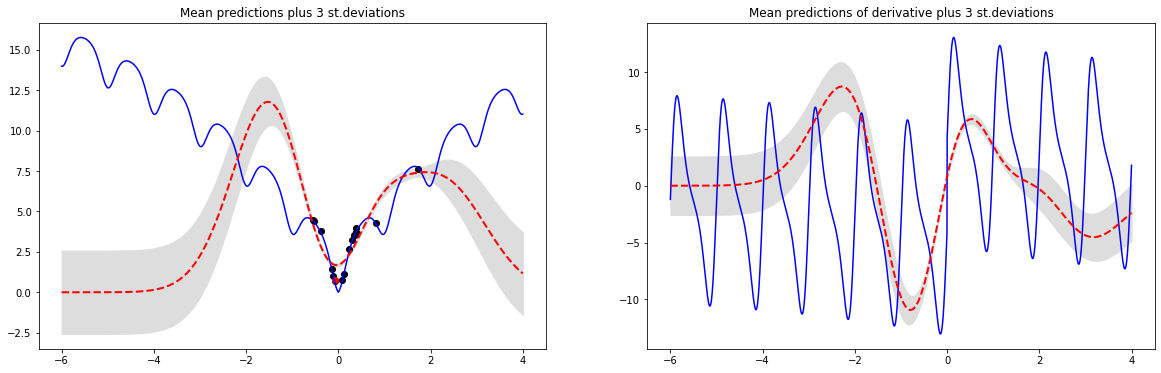

w:  [[-0.22220255]]
lr:  0.1


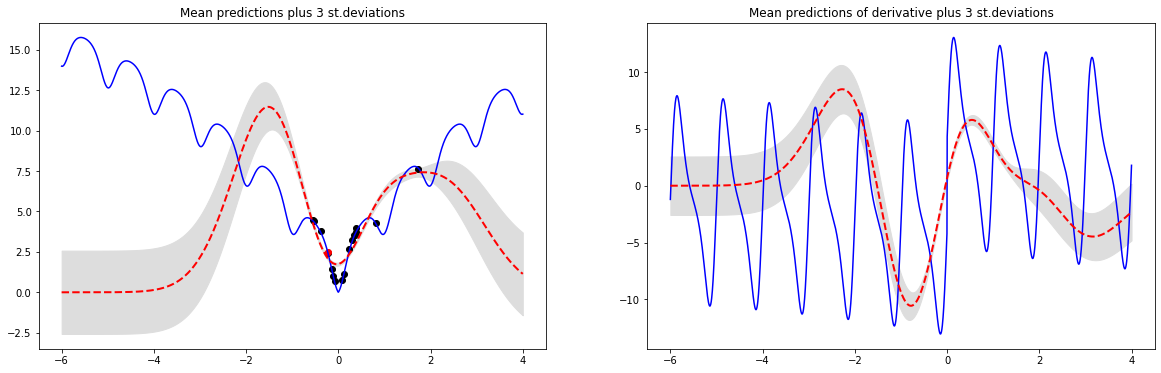

w:  [[-0.28151774]]
lr:  0.1


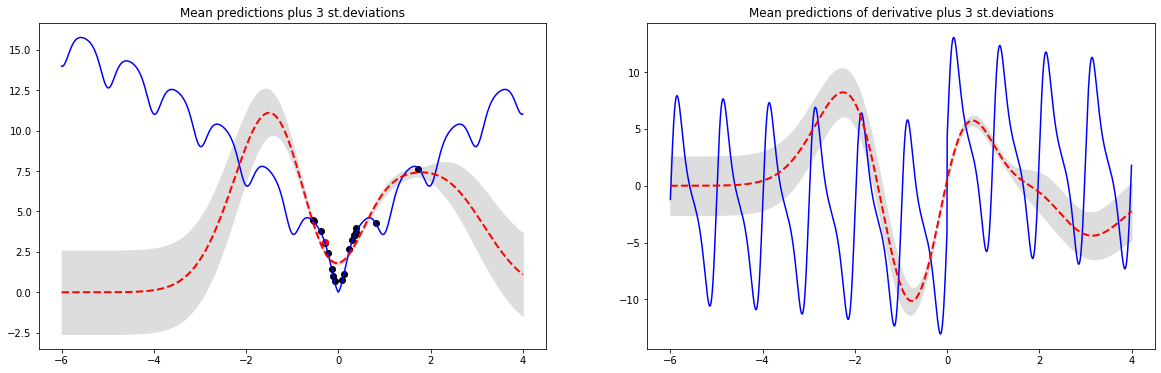

w:  [[-0.25311102]]
lr:  0.1


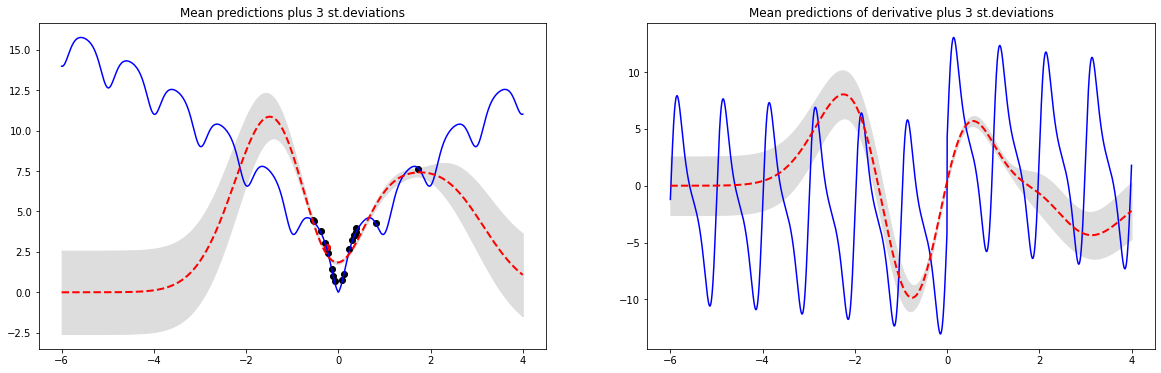

w:  [[-0.16002421]]
lr:  0.1


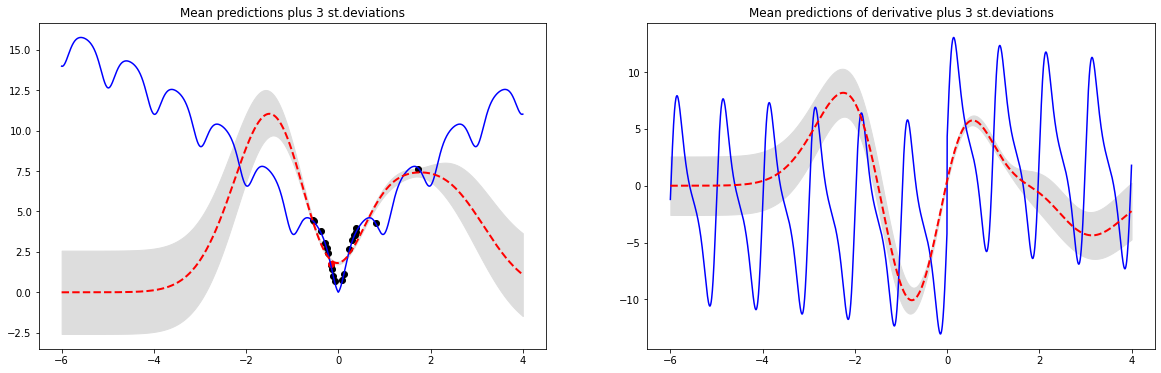

w:  [[-0.03610778]]
lr:  0.1


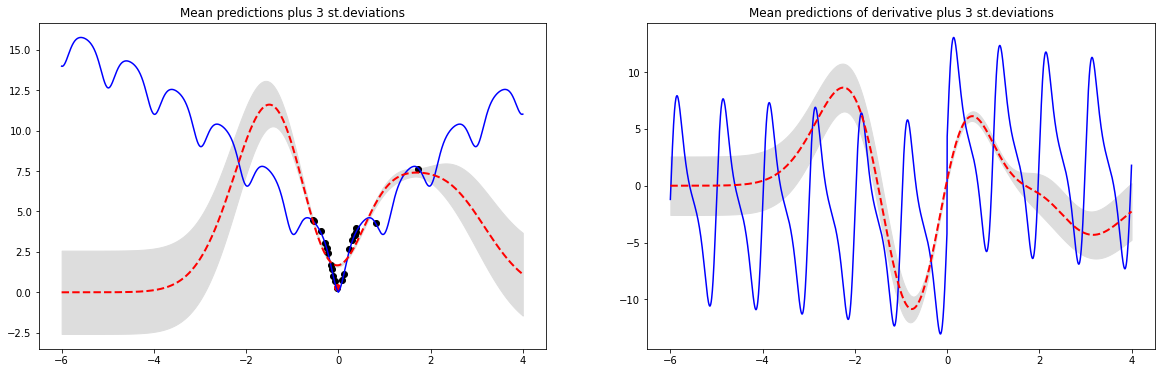

w:  [[0.07996907]]
lr:  0.1


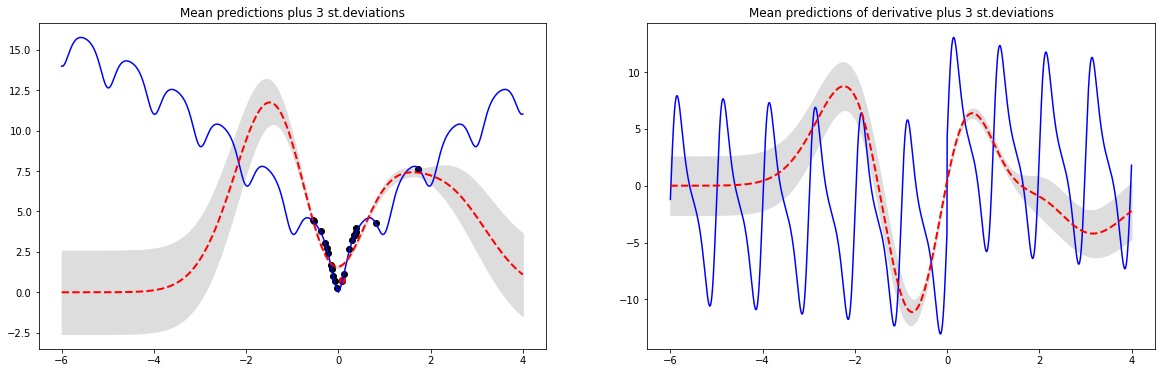

w:  [[0.15394931]]
lr:  0.1


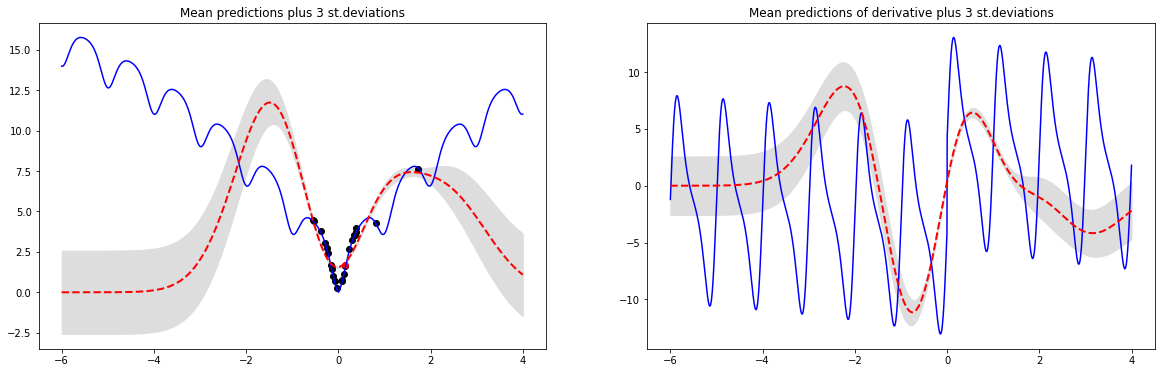

w:  [[0.16985252]]
lr:  0.1


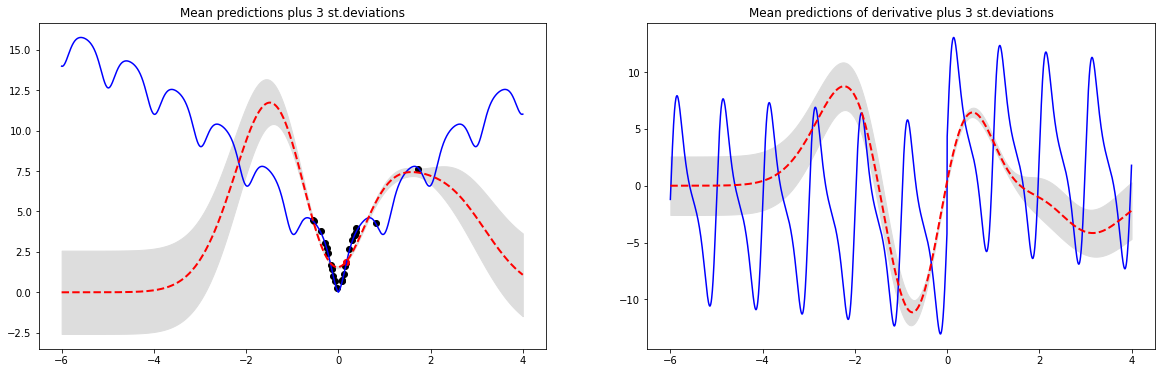

w:  [[0.13069]]
lr:  0.1


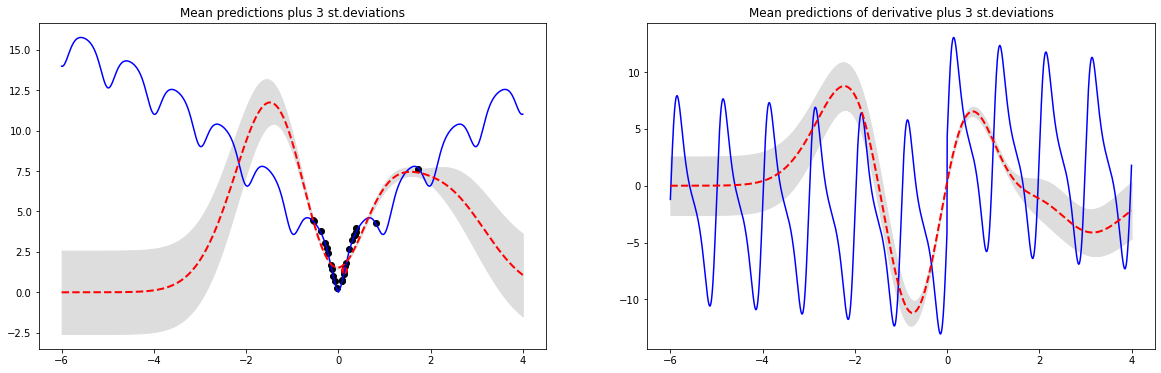

w:  [[0.05225896]]
lr:  0.1


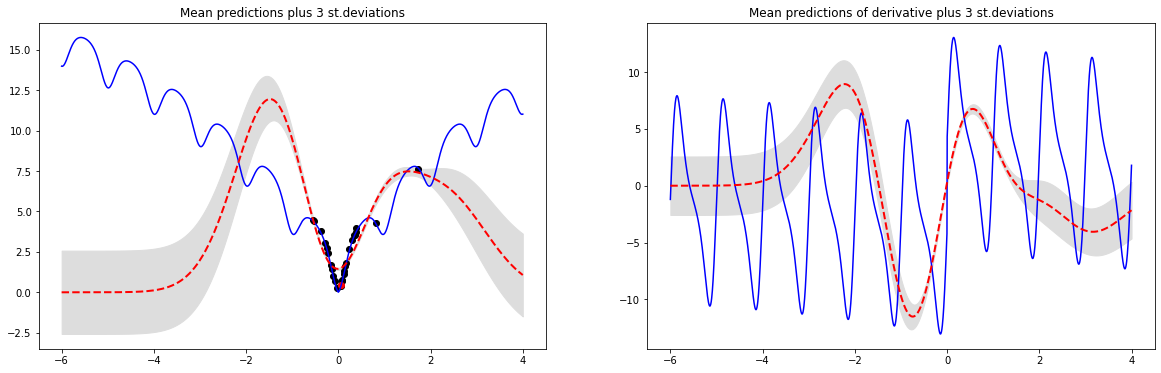

w:  [[-0.04055595]]
lr:  0.1


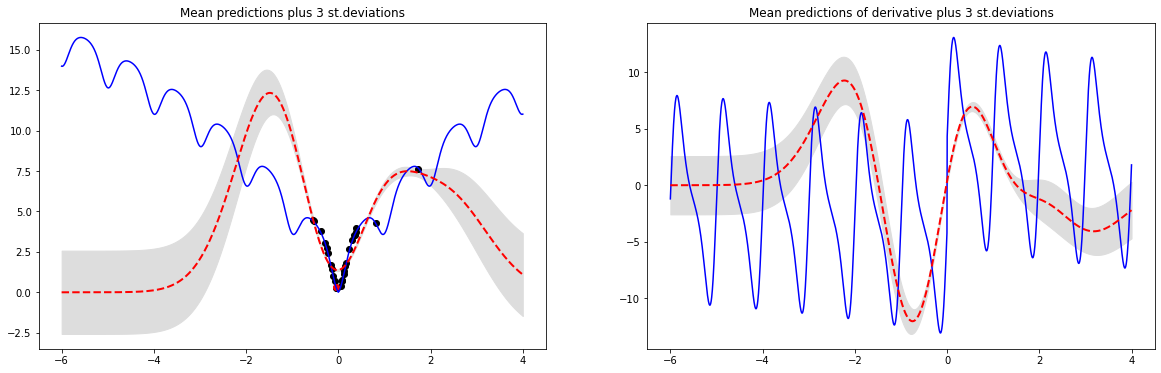

w:  [[-0.11682874]]
lr:  0.1


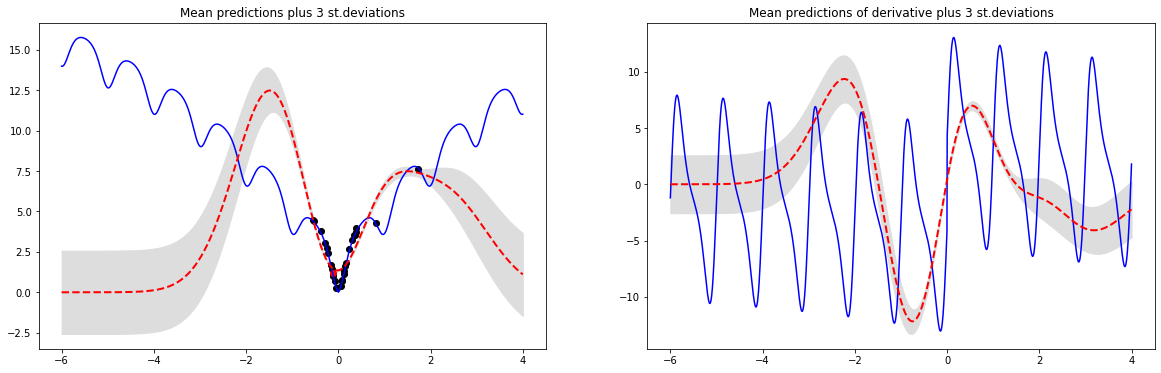

w:  [[-0.14981227]]
lr:  0.1


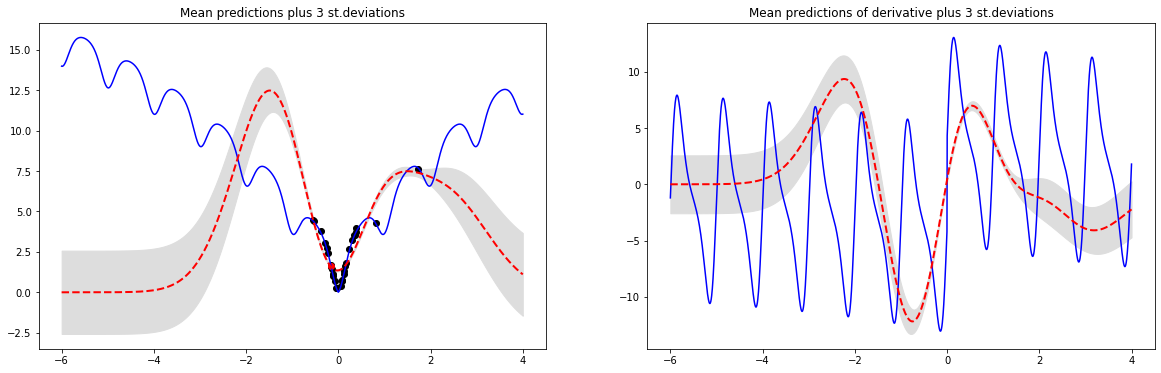

w:  [[-0.13131284]]
lr:  0.1


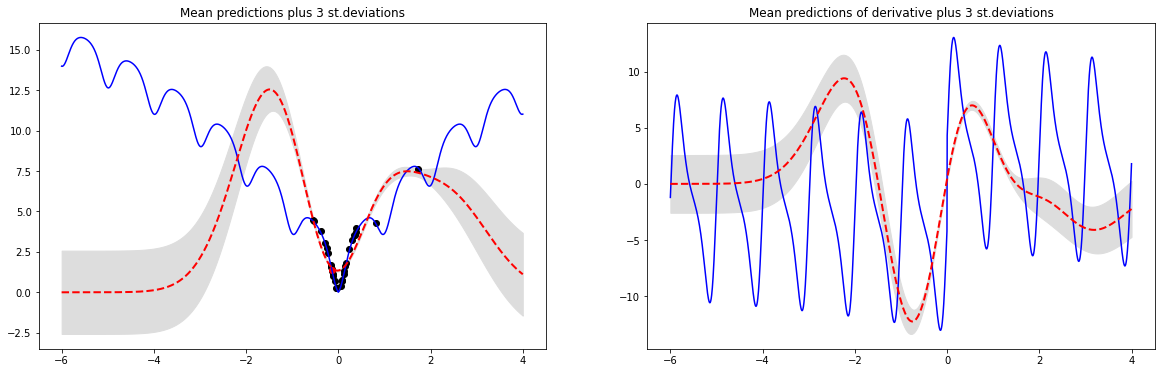

w:  [[-0.07360283]]
lr:  0.1


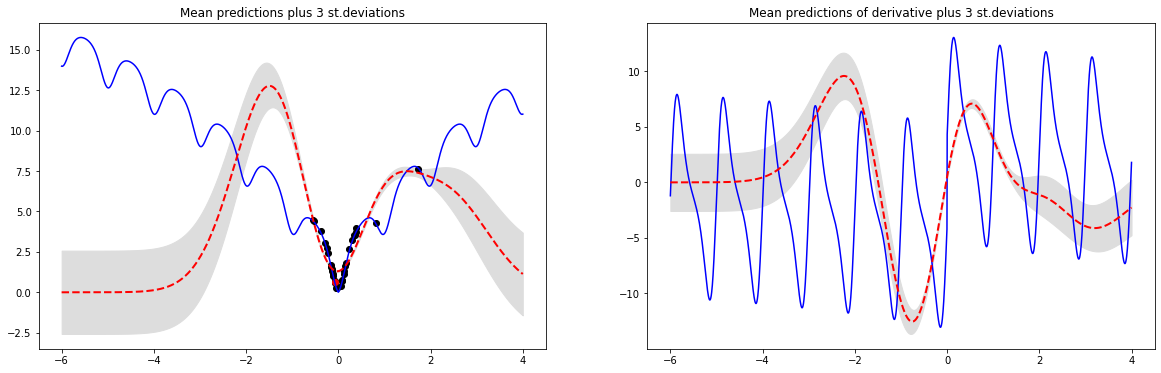

w:  [[-0.00182832]]
lr:  0.1


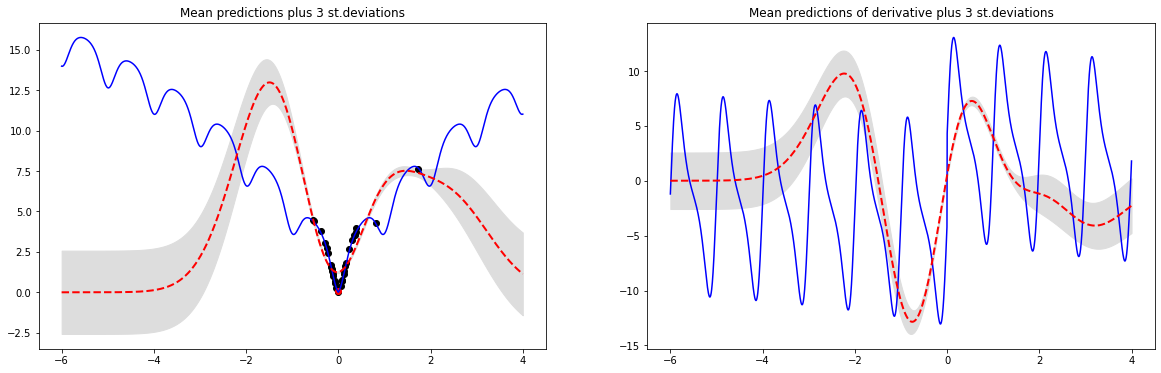

w:  [[0.05599523]]
lr:  0.1


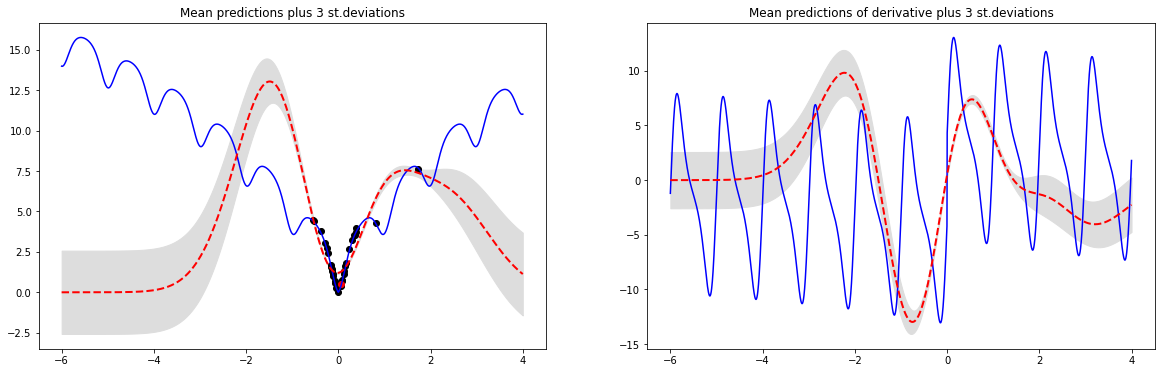

w:  [[0.07988325]]
lr:  0.1


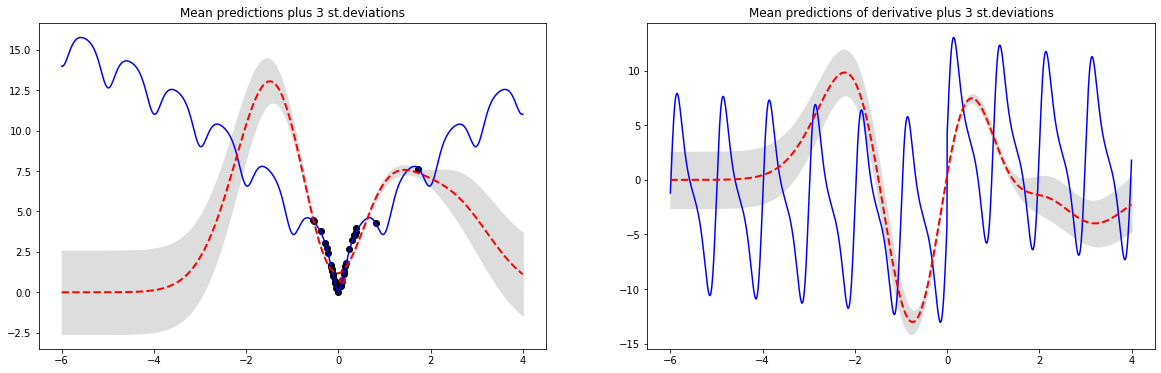

w:  [[0.06462514]]
lr:  0.1


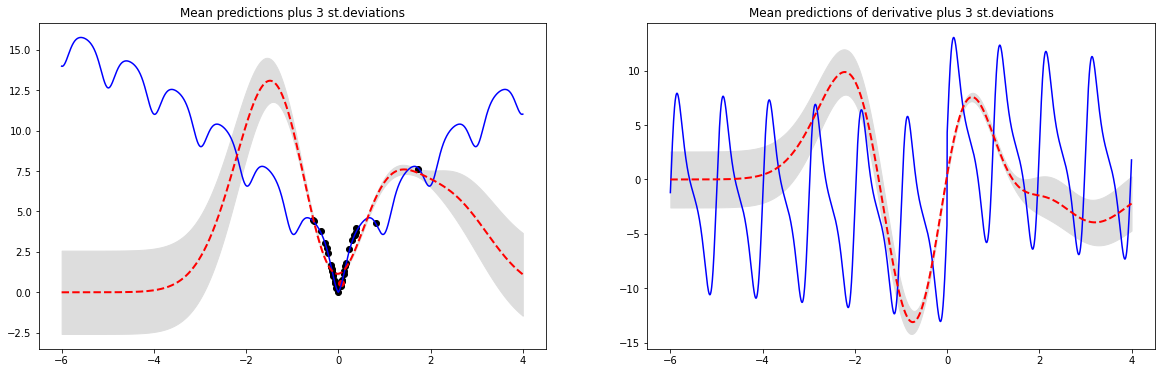

w:  [[0.01942281]]
lr:  0.1


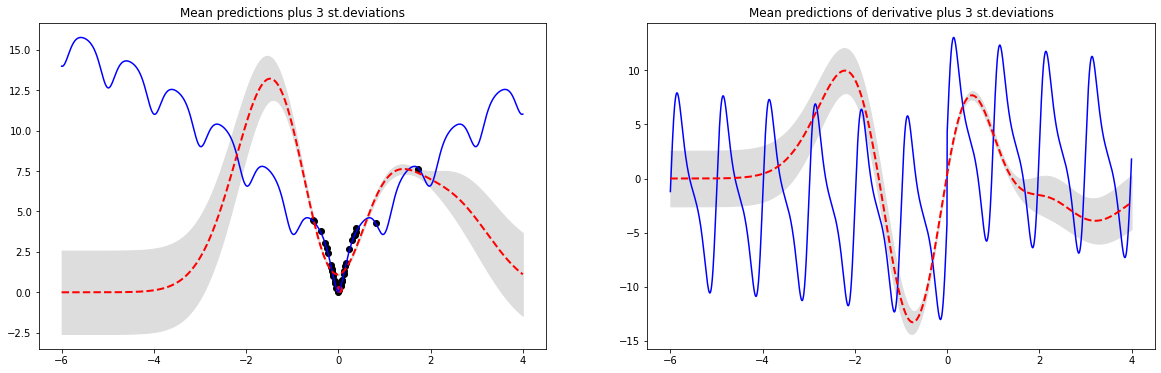

w:  [[-0.0361573]]
lr:  0.1


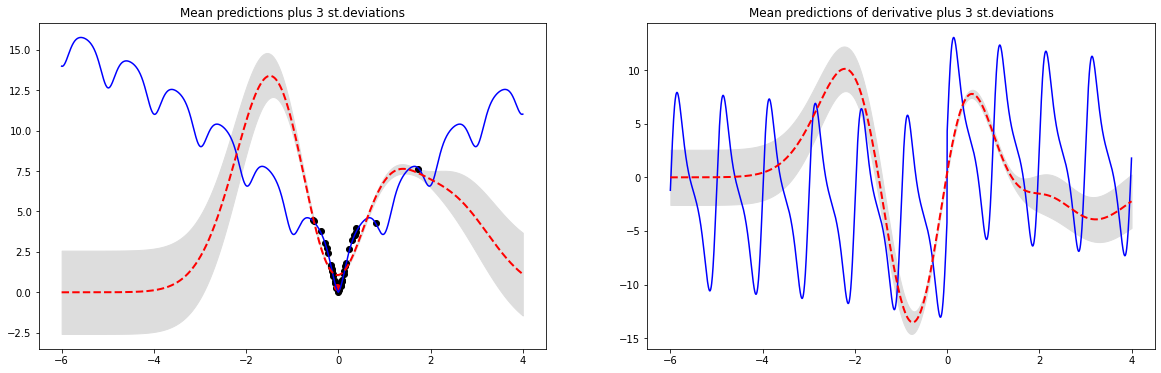

w:  [[-0.07862924]]
lr:  0.1


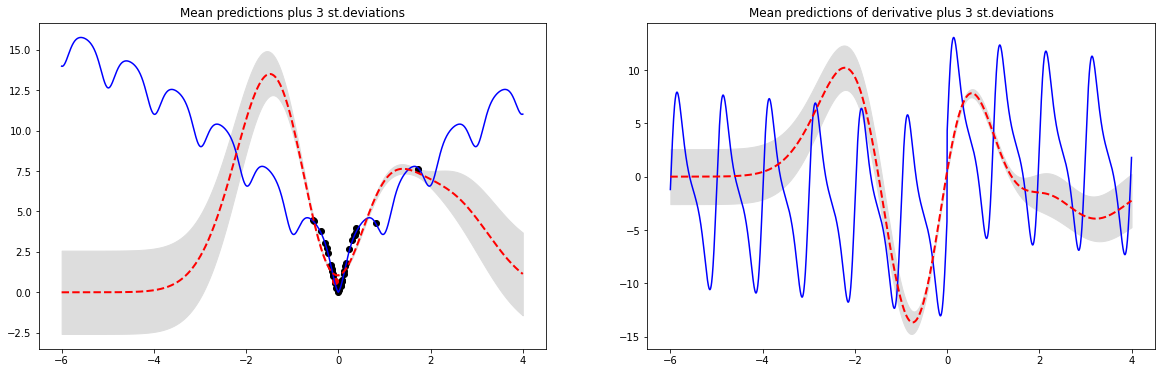

w:  [[-0.09056106]]
lr:  0.1


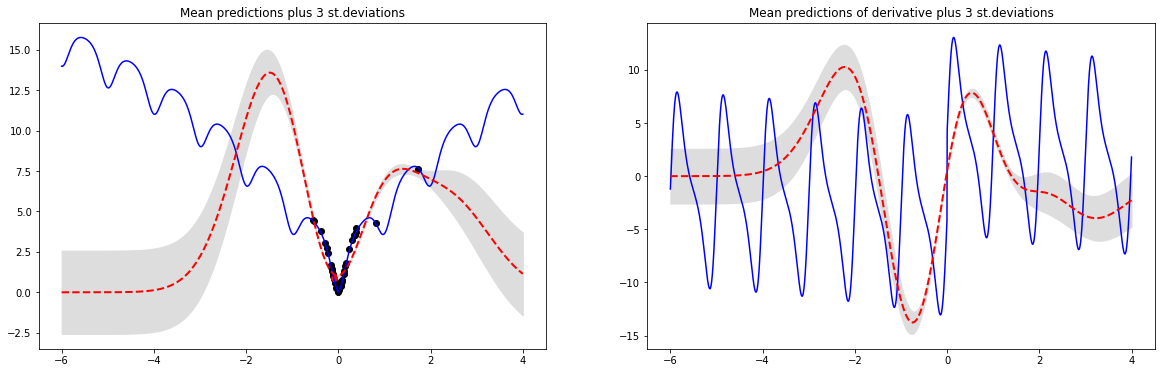

w:  [[-0.06943631]]
lr:  0.1


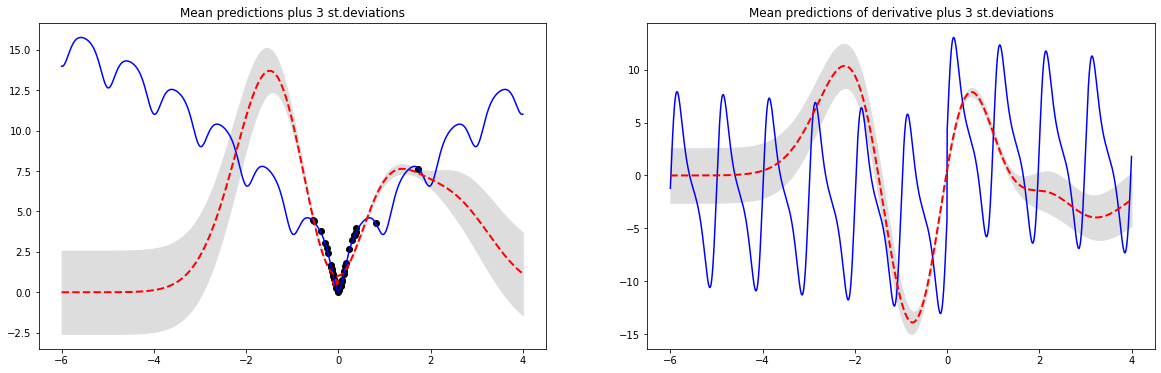

w:  [[-0.02799525]]
lr:  0.1


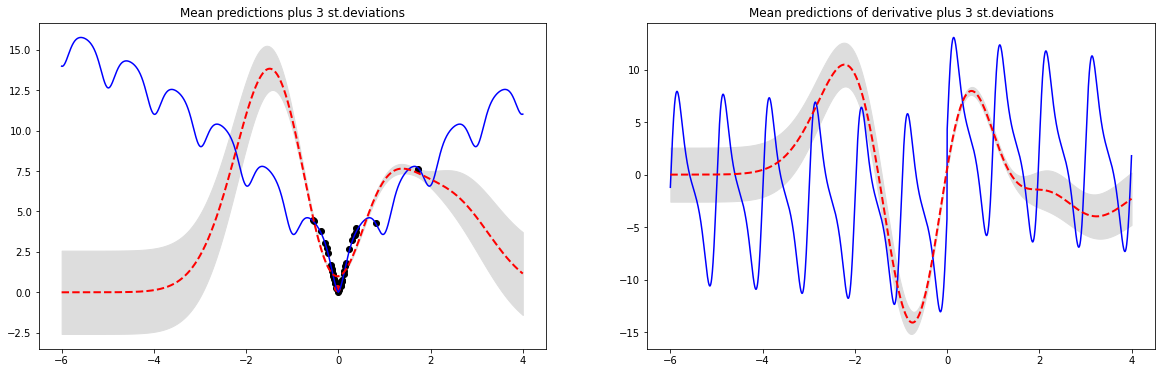

w:  [[0.01302267]]
lr:  0.1


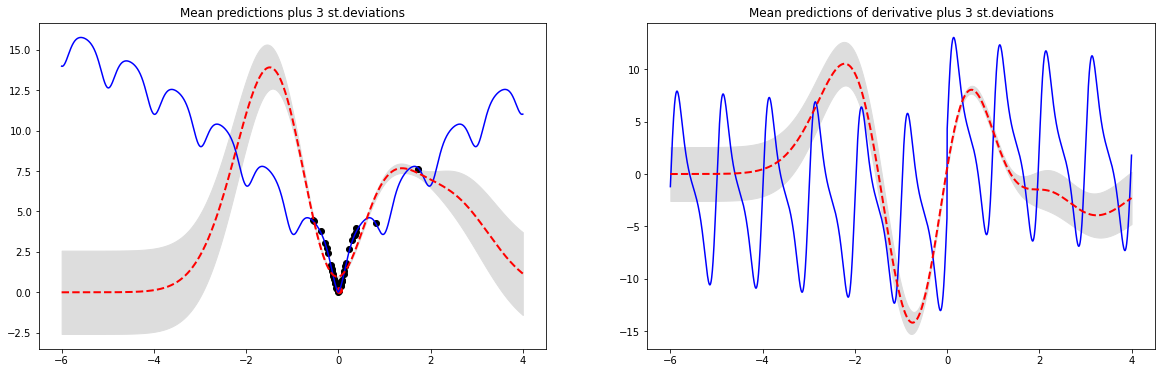

w:  [[0.0351011]]
lr:  0.1


In [16]:
v = np.array([[0]])
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(mesh)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(mesh)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)


    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(mesh, mesh, gp.get_hyper())
    K_11 = gp.K11(mesh)
    K_01 = gp.K01(mesh)

    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(np.squeeze(gp.X), np.squeeze(gp.y), 'ko')
    ax1.plot(np.squeeze(w), np.squeeze(f(w)), 'ro')
    
#     ax1.plot(mesh.flat, np.sin(mesh.flat) + (0.1*mesh).flat, 'b-')
    ax1.plot(mesh.flat, functions.Ackley_1().func(mesh), 'b-')
    ax1.fill_between(mesh.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")

    ax1.plot(mesh, mu, 'r--', lw=2)
    fig.savefig('predictive.png', bbox_inches='tight')
    ax1.set_title('Mean predictions plus 3 st.deviations')
#     ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
#     ax2.plot(mesh.flat, np.cos(mesh.flat) + 0.1, 'b-')
    ax2.plot(mesh.flat, approx_grad, 'b-')
    ax2.fill_between(mesh.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

    ax2.plot(mesh.flat, mu_grad, 'r--', lw=2)
    fig.savefig('predictive_grad.png', bbox_inches='tight')
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
#     ax2.axis([-5, 15, -3, 3])

    filename = 'Ackley_' + str(i) + '_noise' +'.png' # name for different 
    pl.savefig('Result_Plots/' + filename)
    pl.show()  

    
    # gradient ascent
#     gradient = grad_sample(gp, w)
#     desc = -gradient
    
#     # automatically choose the learning rate
#     lr = lr_init
#     while f(w + lr*gradient) > f(w) + alpha*lr*np.dot(desc, gradient):
#         # while condition not satisfied, divide the learning rate by two
#         lr = 0.5 * lr
    
#     w = np.clip(w + lr * desc, -1, 15) # gp.SearchSpace

    #     2. nesterov
#     v = 0.9*v + lr*grad_mean(gp, w-0.9*v)
#     w = np.clip(w - v, -1, 15) + np.random.normal(0, 0.1, 1)
    
    # 3. Adam
    # approximate first and second moment
    gt = grad_mean(gp, w)
    mt = b1 * mt + (1 - b1) * gt
    vt = b2 * vt + (1 - b2) * np.square(gt)

    # bias corrected moment estimates
    mhat = mt / (1 - b1 ** i )
    vhat = vt / (1 - b2 ** i )

    # update the params
    delta_w = -1 * eta * mhat/(np.sqrt(vhat) + epsilon)
    w = w + delta_w
    
    print('w: ', w)
    print('lr: ', lr)
    history.append( f(w) )
    history_lr.append(lr)
    gp.add_data(w, f(w))
    gp.fit()

In [17]:
# Creates the .gif from the saved plots for the 2D_Plots dir.
filenames = []
for i in range(1, n_iter):
#     filename = 'sin_' + str(i) + '_noise' + '.png'
    filename = 'Ackley_' + str(i) + '_noise' + '.png'
    filenames.append(filename)

frames=[]
for filename in filenames:
    frames.append(imageio.imread('Result_Plots/' + filename))
# exportname = 'sin_Adam.gif'
exportname = 'Ackley1d_Adam.gif'

kargs = { 'duration': 0.5 }
imageio.mimsave(exportname, frames, 'GIF', **kargs)

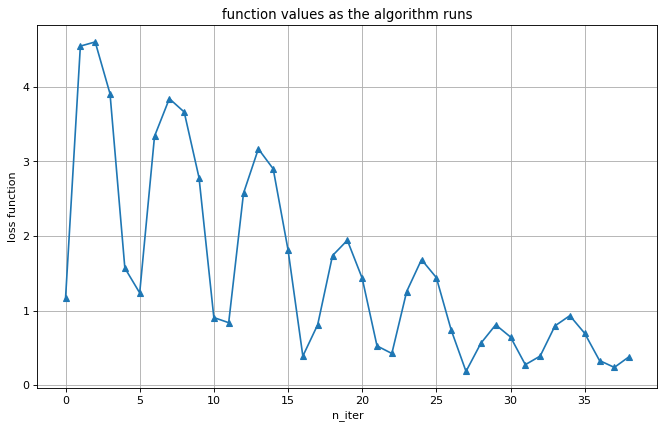

In [18]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [16]:
# plot lr
# pl.figure(figsize=(10, 6), dpi=80)
# pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

In [17]:
# print(history_lr)

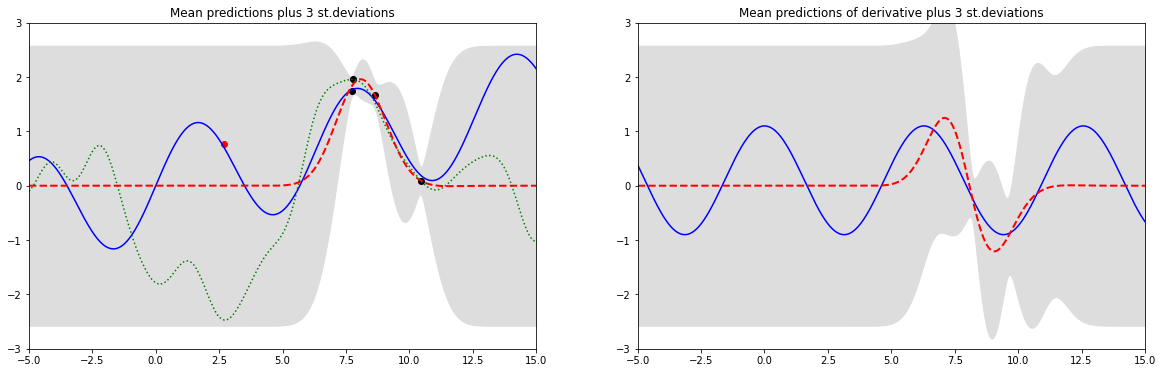

w:  [2.70385193]


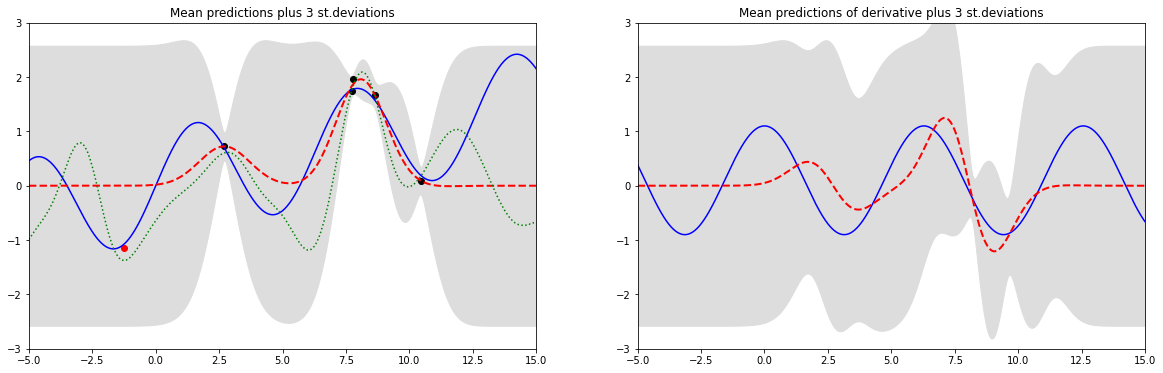

w:  [-1.24812406]


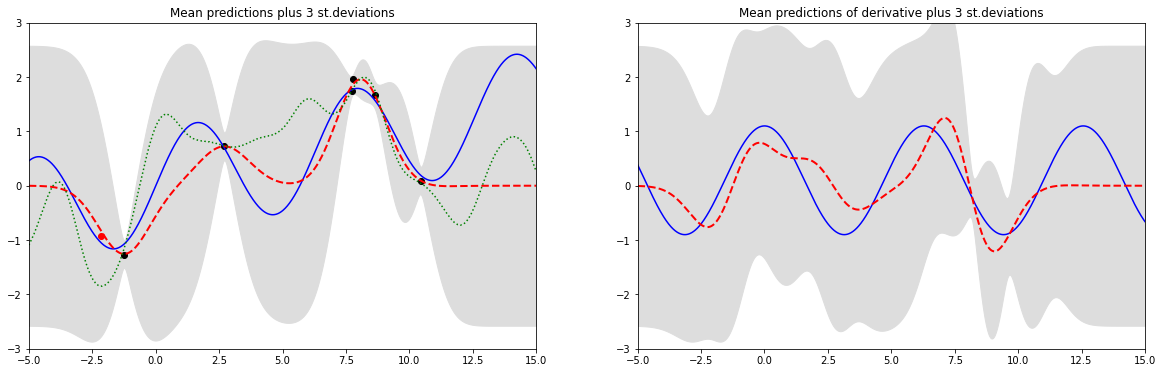

w:  [-2.14857429]


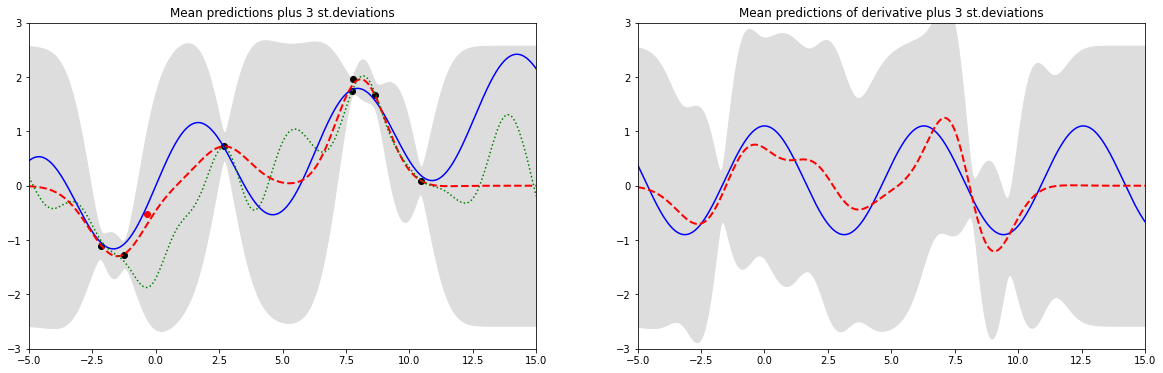

w:  [-0.35767884]


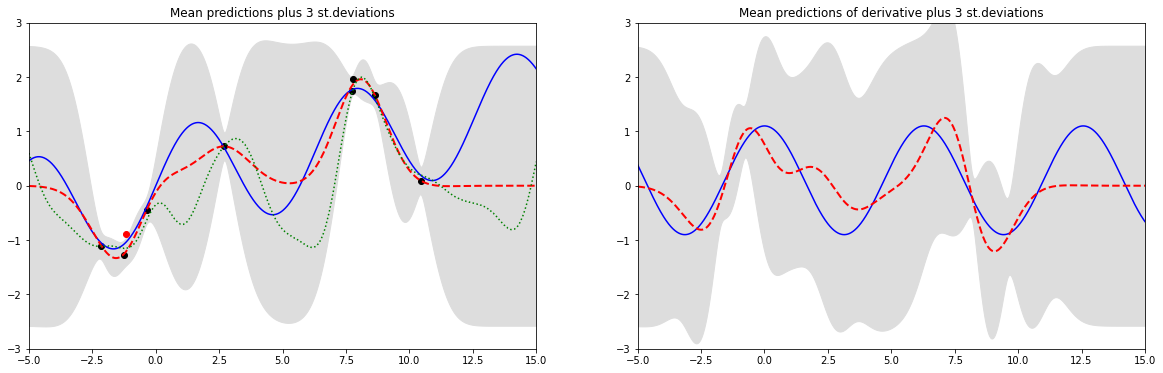

w:  [-1.18809405]


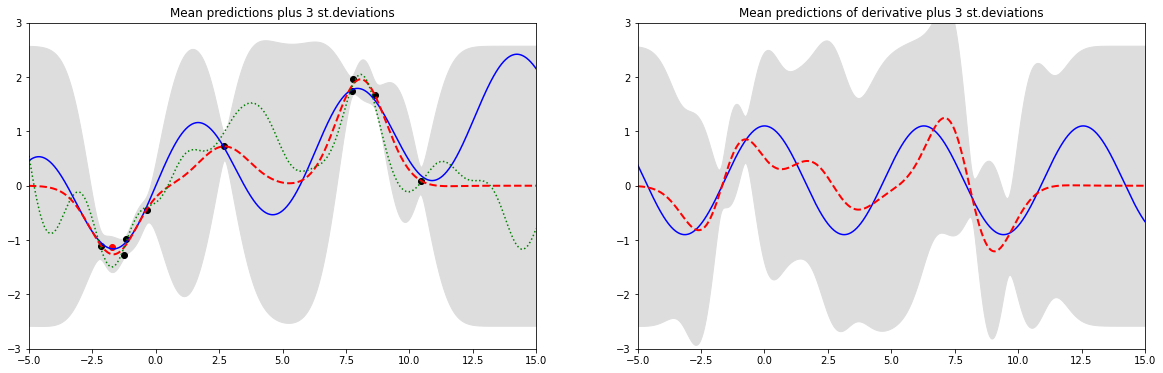

w:  [-1.73836918]


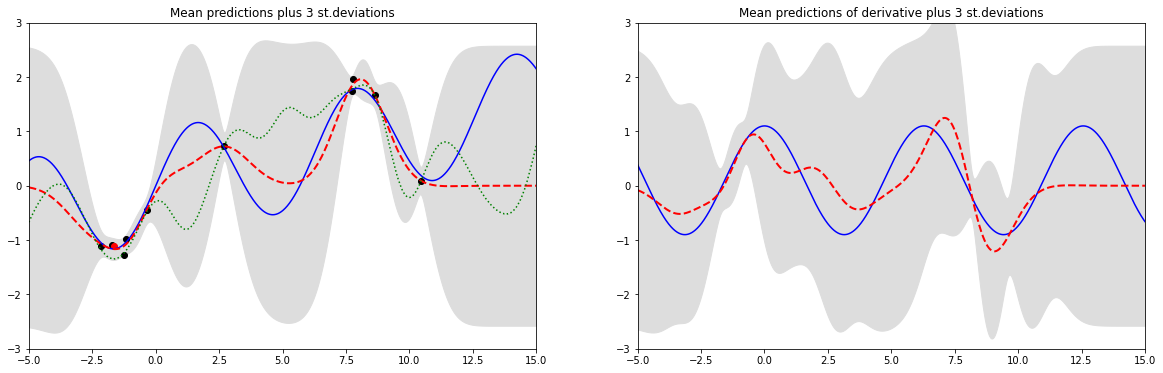

w:  [-1.65832916]


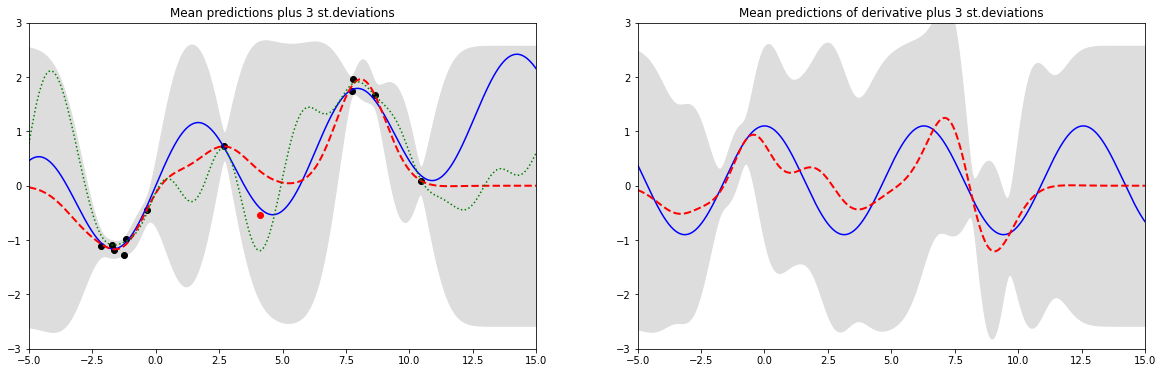

w:  [4.10455228]


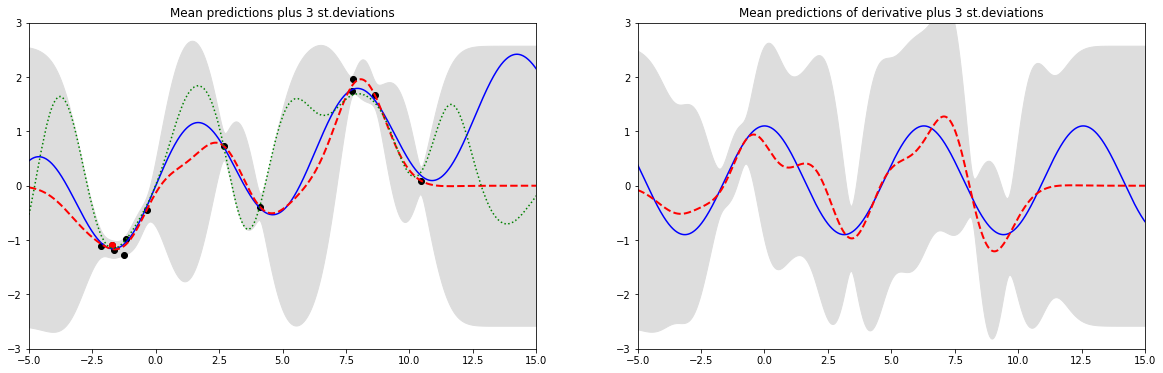

w:  [-1.70835418]


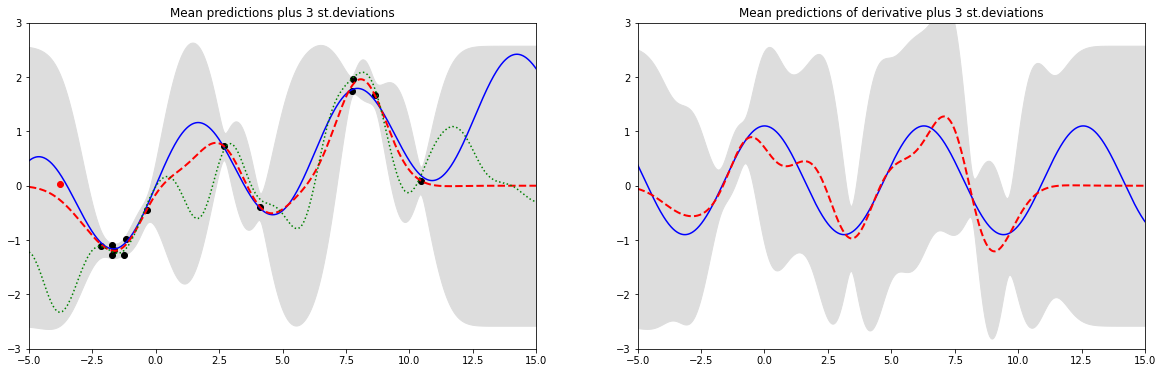

w:  [-3.77938969]


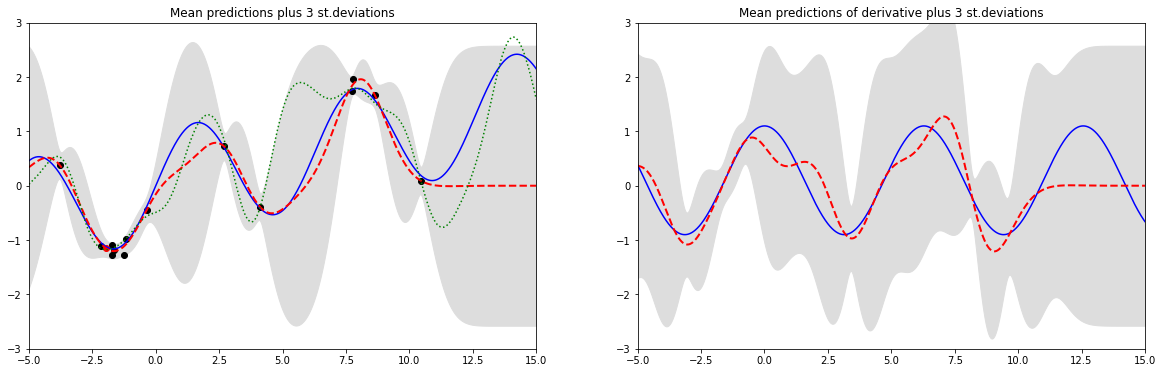

w:  [-1.95847924]


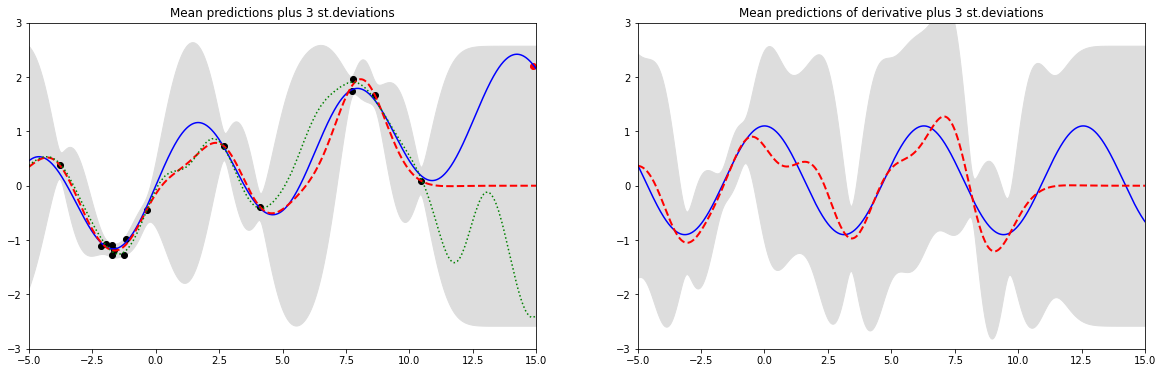

w:  [14.85992996]


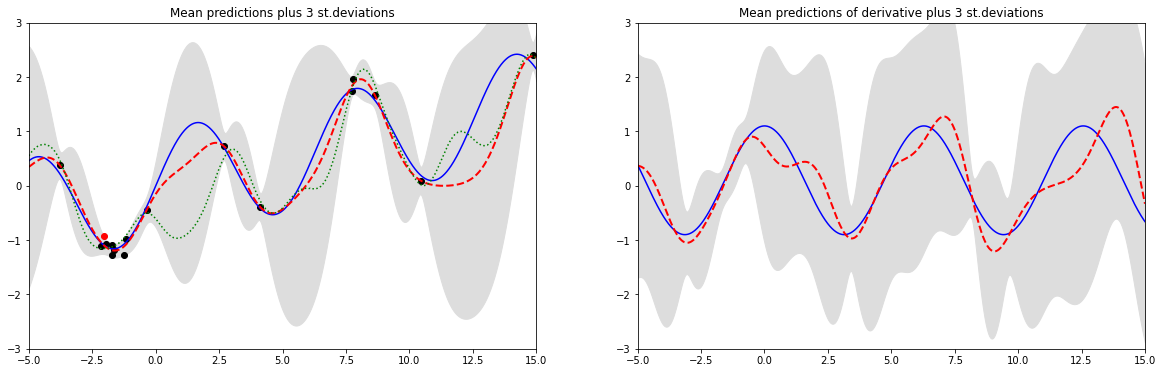

w:  [-2.05852926]


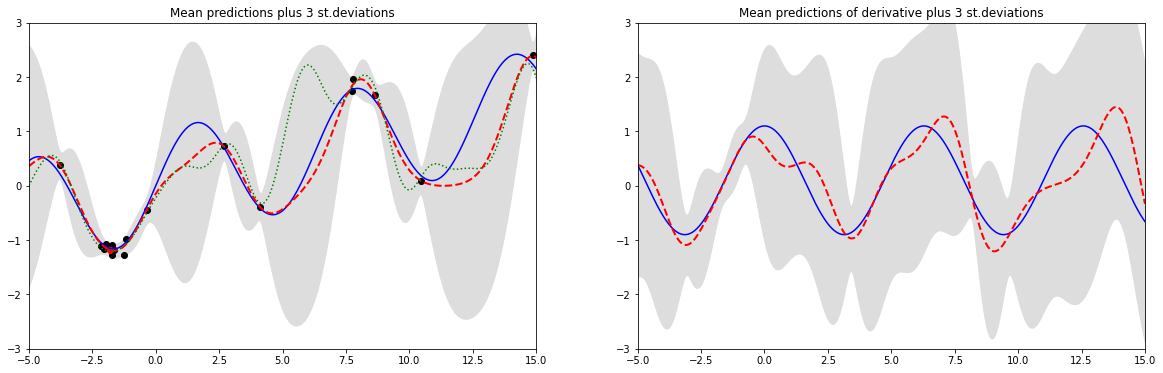

w:  [-1.7883942]


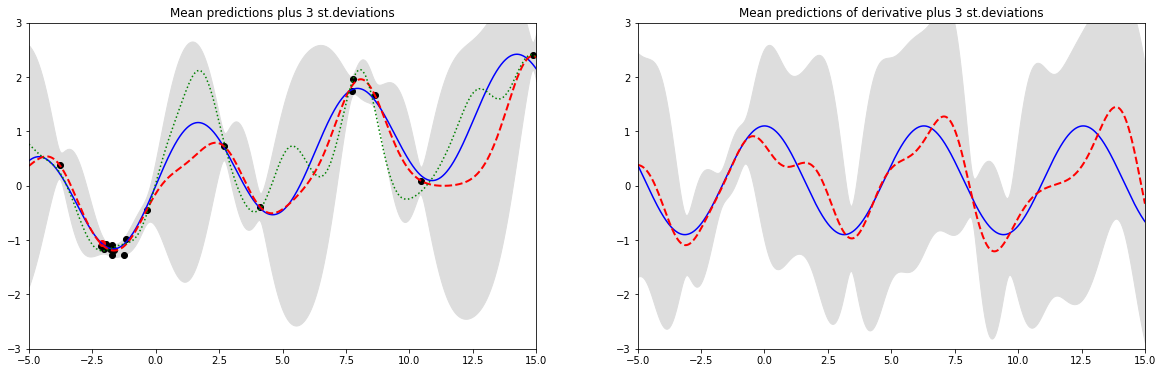

w:  [-2.11855928]


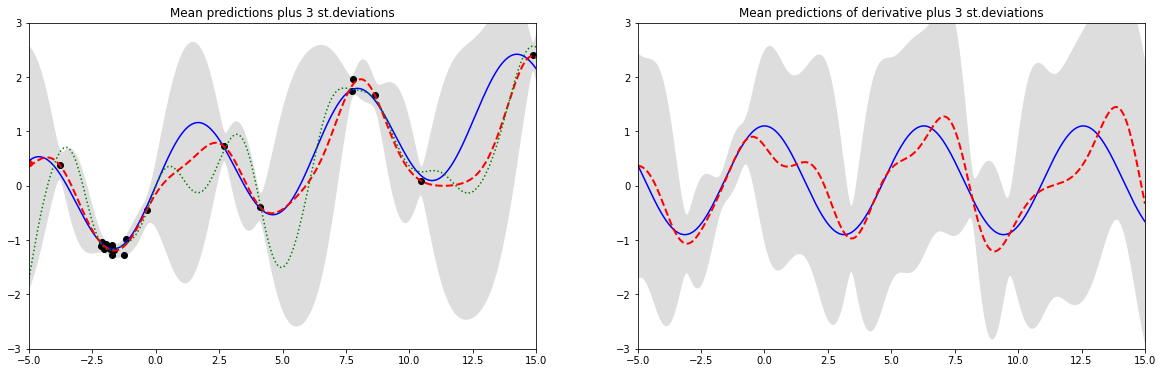

w:  [-5.]


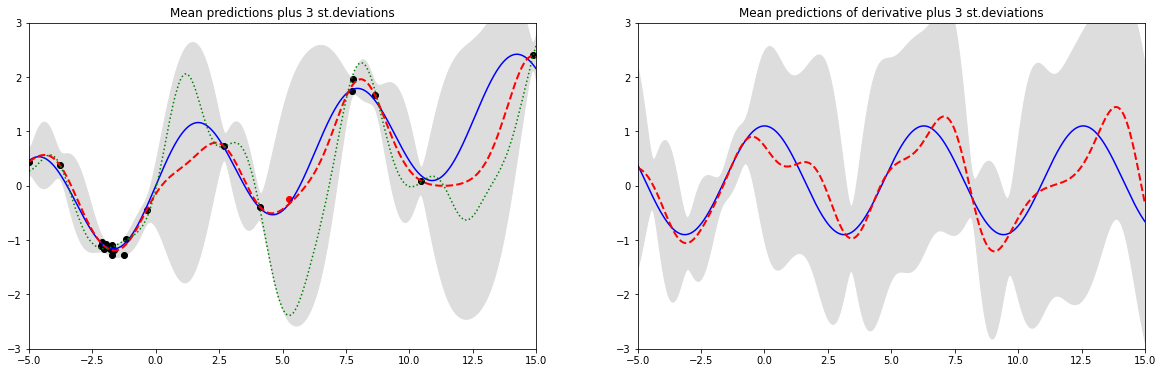

w:  [5.24512256]


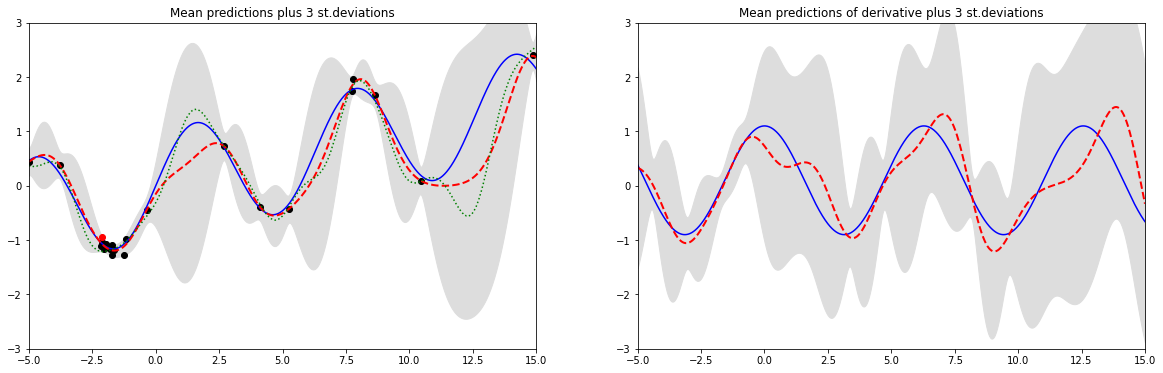

w:  [-2.10855428]


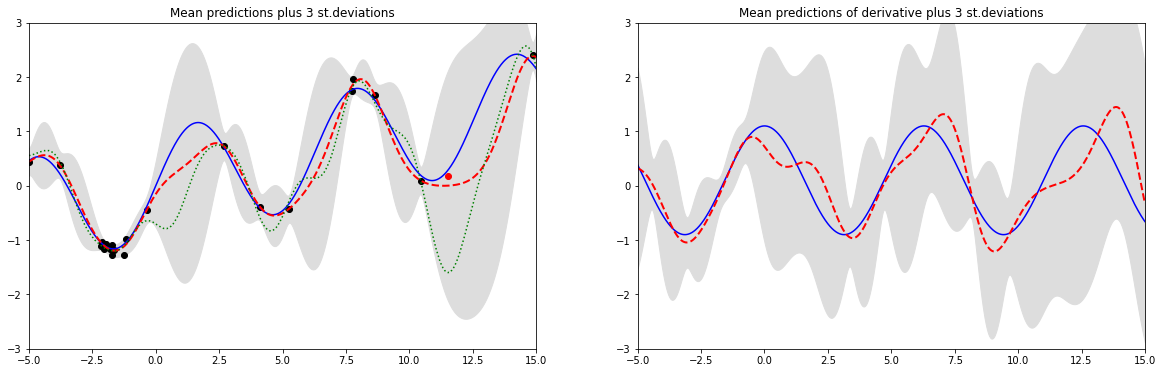

w:  [11.52826413]


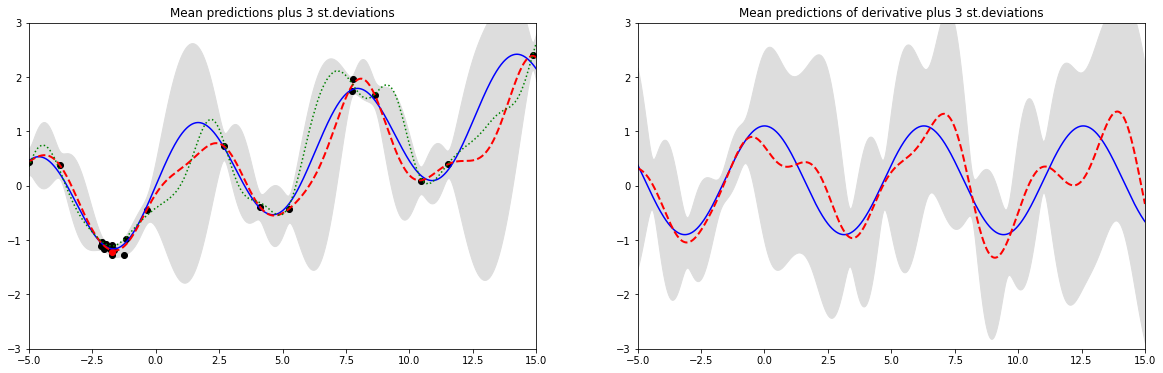

w:  [-1.70835418]


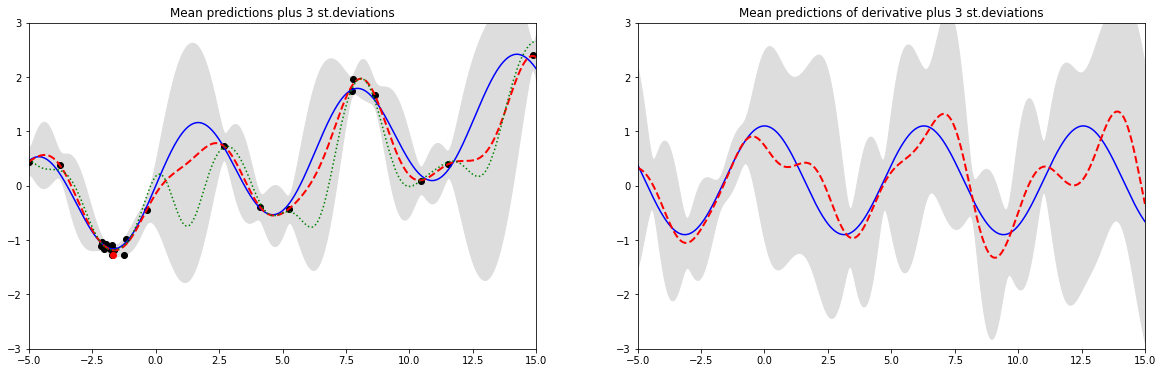

w:  [-1.66833417]


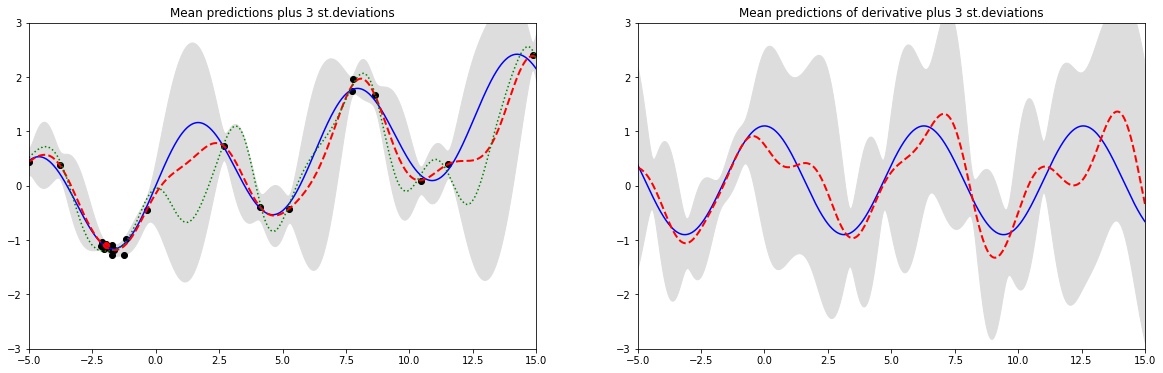

w:  [-1.94847424]


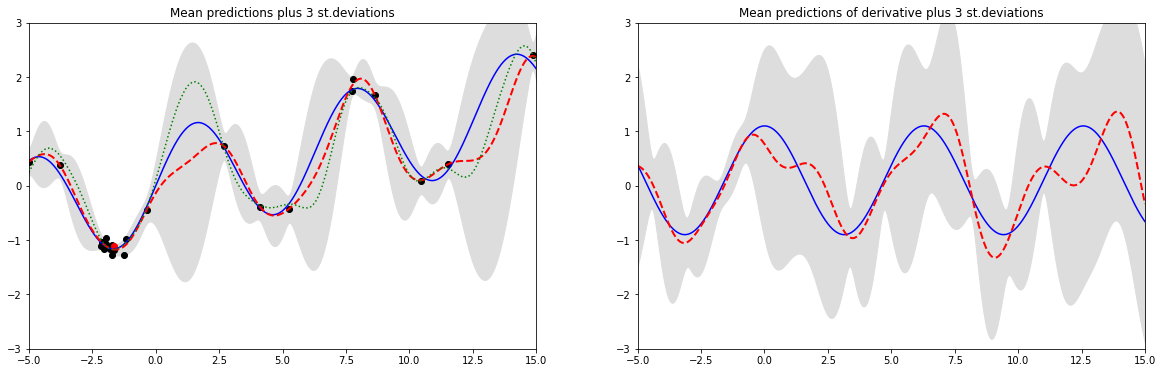

w:  [-1.65832916]


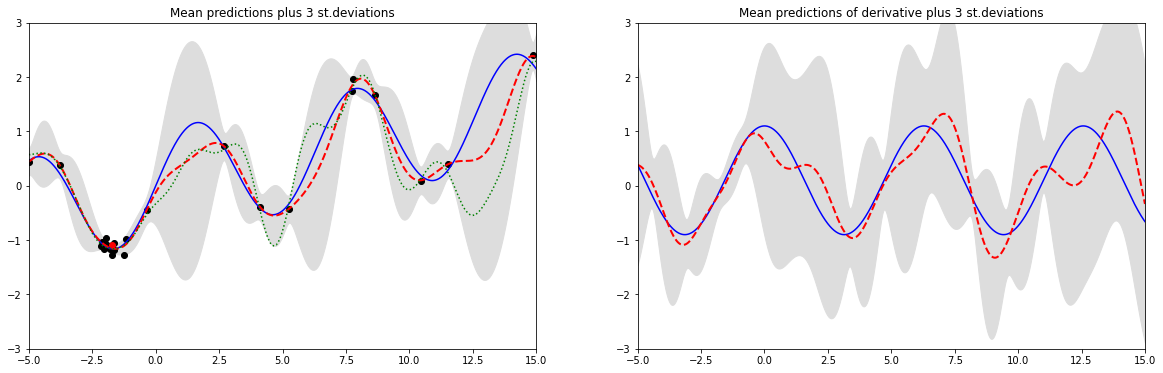

w:  [-1.70835418]


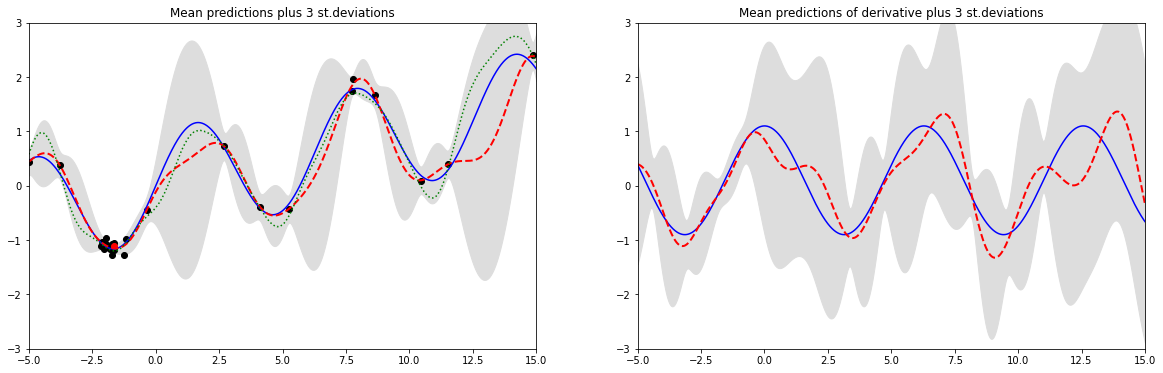

w:  [-1.64832416]


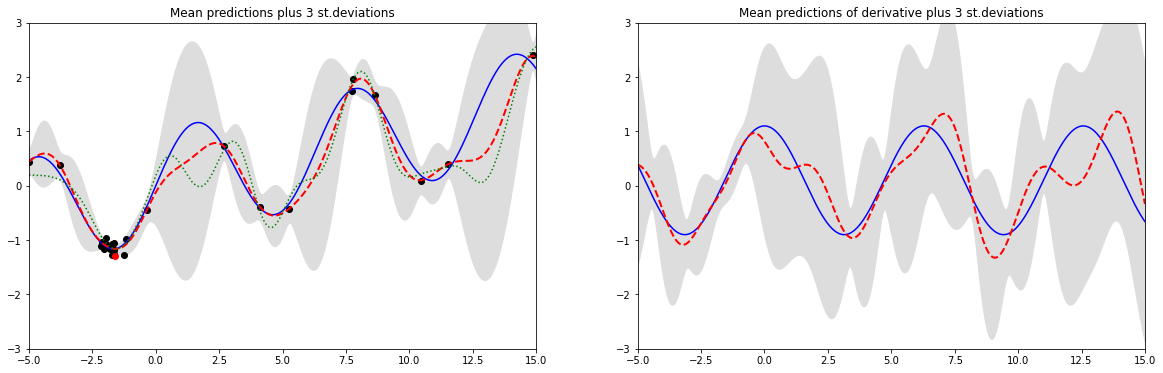

w:  [-1.58829415]


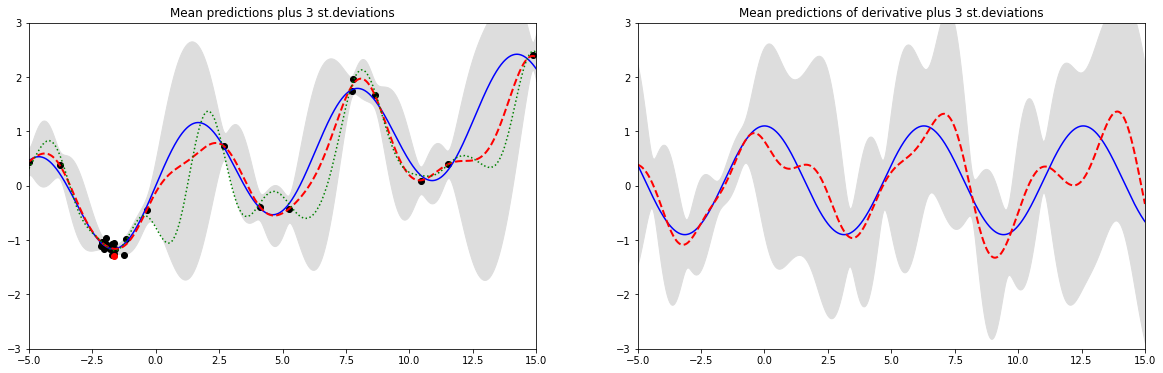

w:  [-1.63831916]


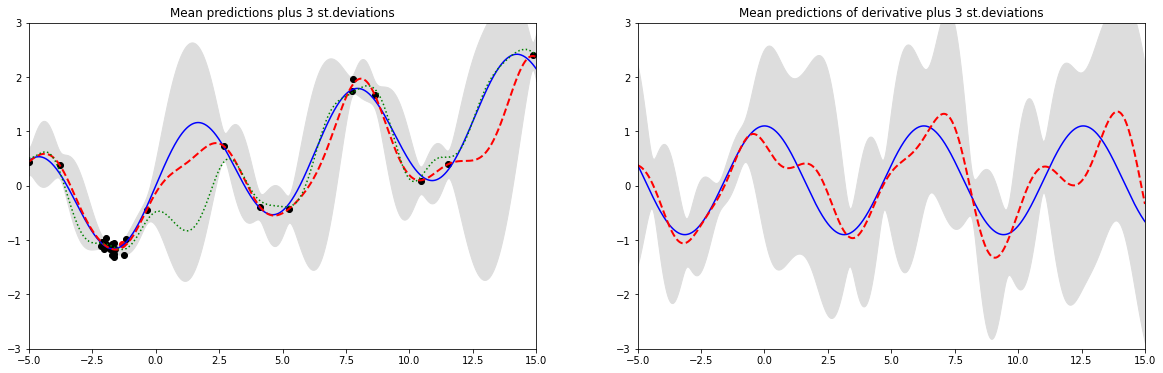

w:  [-1.34817409]


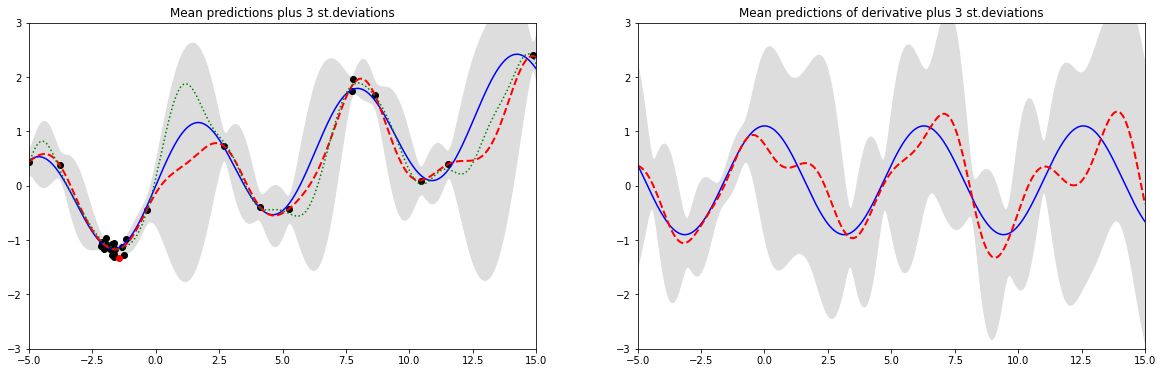

w:  [-1.44822411]


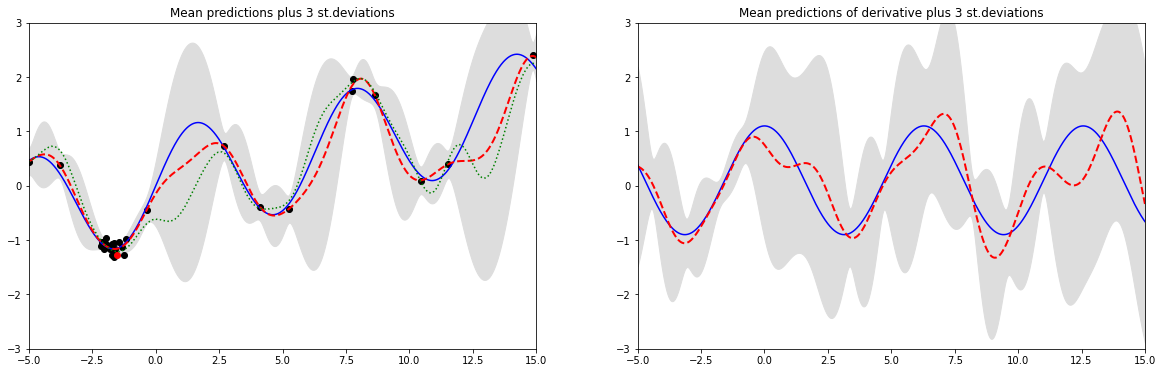

w:  [-1.52826413]


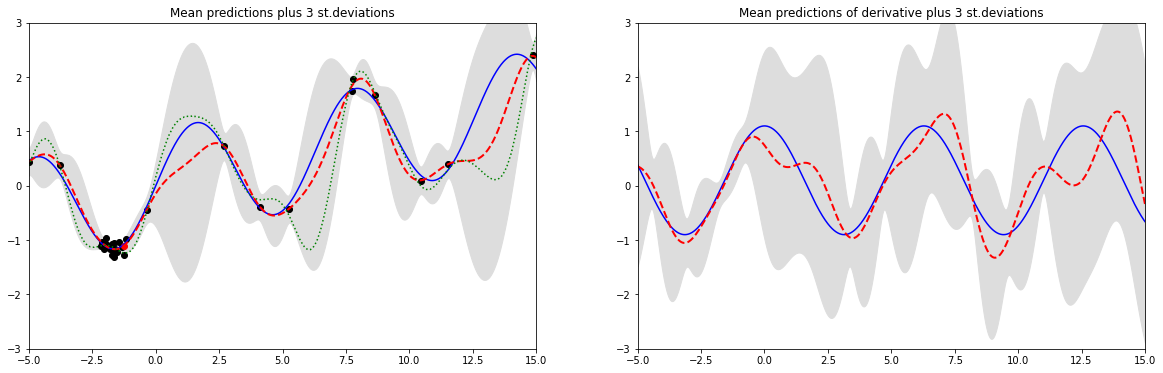

w:  [-1.24812406]


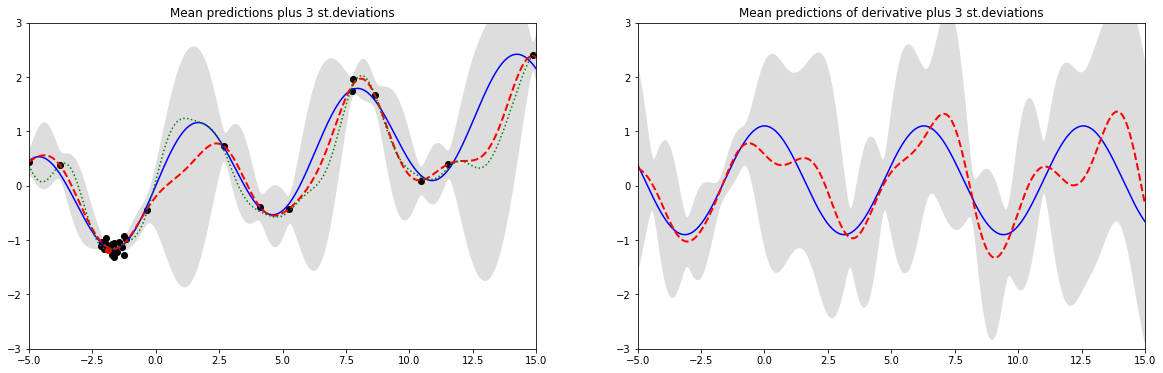

w:  [-1.89844922]


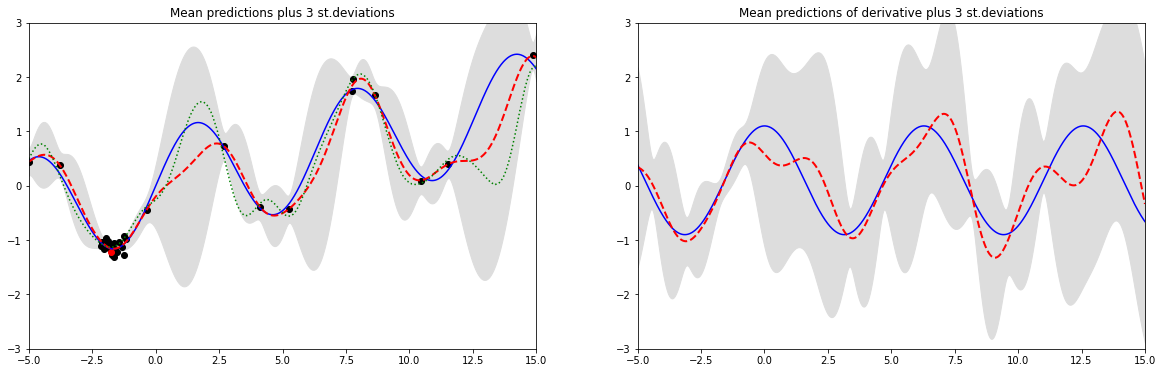

w:  [-1.77838919]


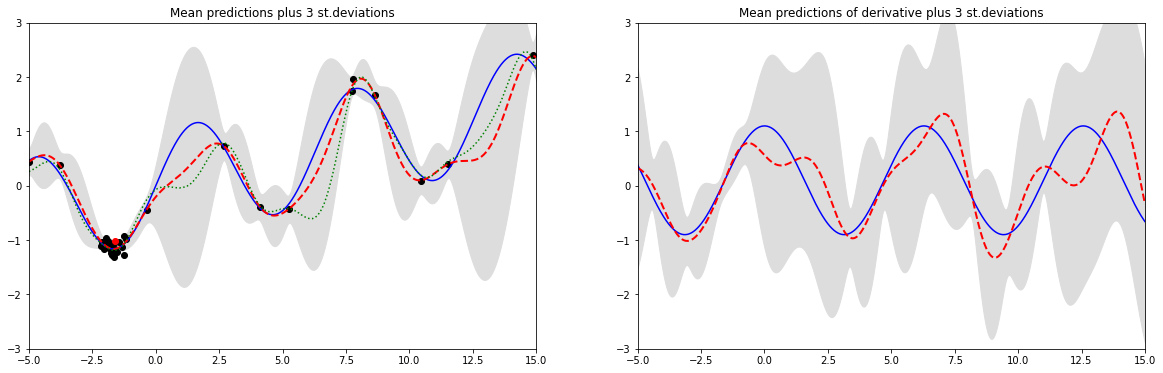

w:  [-1.59829915]


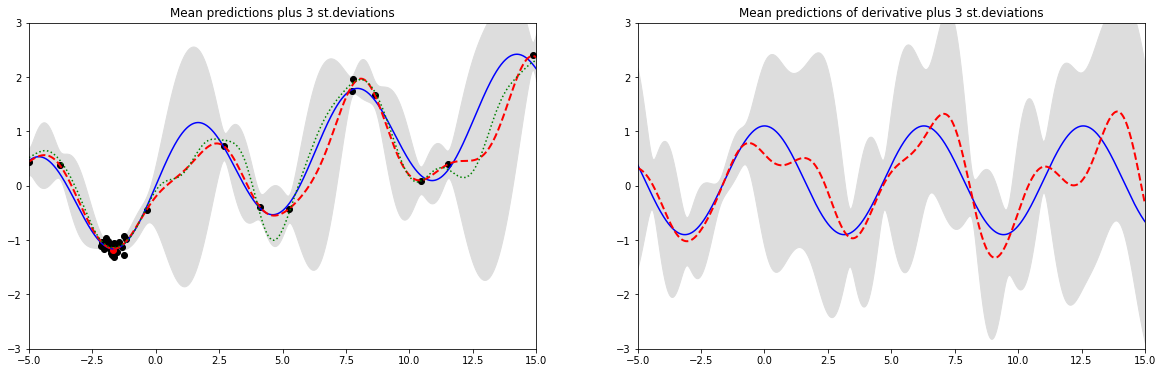

w:  [-1.67833917]


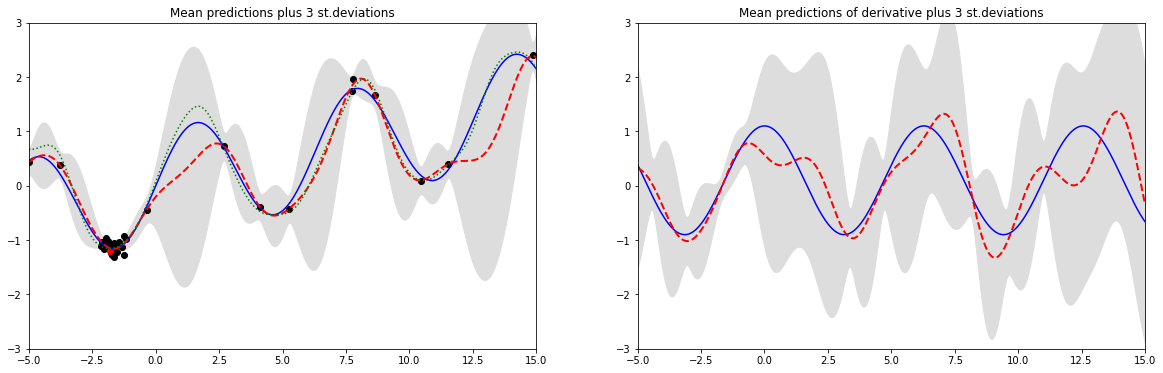

w:  [-1.7983992]


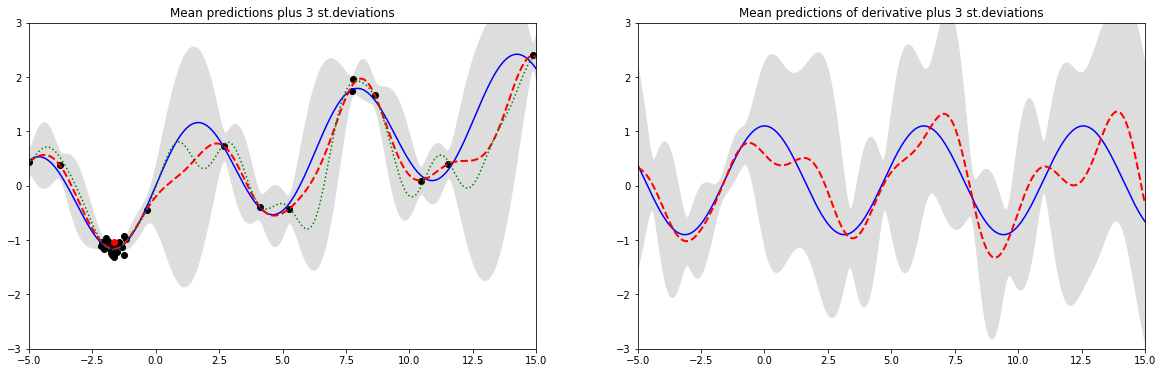

w:  [-1.65832916]


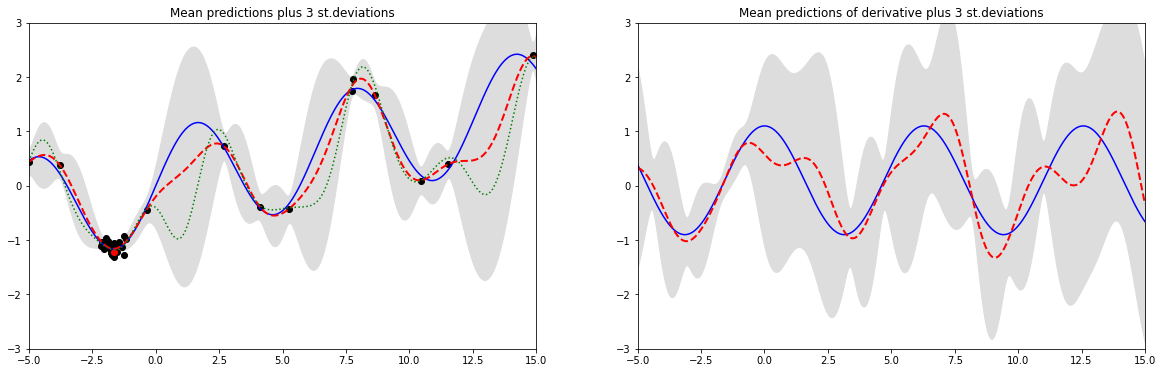

w:  [-1.63831916]


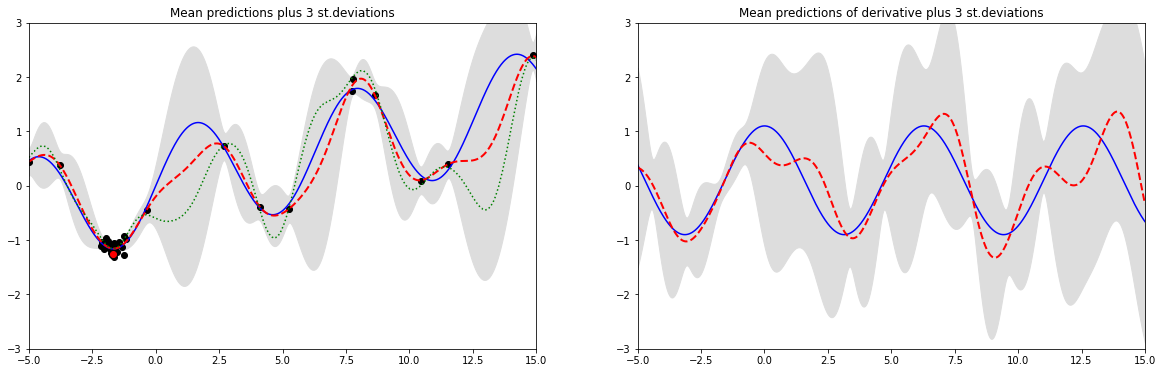

w:  [-1.67833917]


In [11]:
### Thompson Sampling

gp = GP_grad(bounds, Noise, Noise_level)
n_mesh = 2000
mesh = np.linspace(-5, 15, n_mesh).reshape((-1, dim))
np.random.seed(seed)  

X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(4, dim)))
gp.set_data(X, f(X))
gp.fit()
mu, covar = gp.posterior(mesh)

n_iter = 40
history = []
w = X[0].reshape(-1, 1)

for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(mesh)
    s = np.sqrt(np.diag(covar))
    mu = np.squeeze(mu)

    # posterior of GP derivative given gp.X, gp.y
    mu_grad, covar_grad = gp.posterior_grad(mesh)
    s_grad = np.sqrt(np.diag(covar_grad))
    mu_grad = np.squeeze(mu_grad)


    # joint MVN
    K = gp.cov_RBF(gp.X, gp.X, gp.get_hyper())
    K_ = gp.cov_RBF(mesh, mesh, gp.get_hyper())
    K_11 = gp.K11(mesh)
    K_01 = gp.K01(mesh)
    
    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_mesh)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_mesh, dim)))
    arg_min = np.argmin(f_post)
    w = mesh[arg_min]
    
    fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(20, 6))

    # plot function
    ax1.plot(np.squeeze(gp.X), np.squeeze(gp.y), 'ko')
    ax1.plot(np.squeeze(w), np.squeeze(f(w)), 'ro')
    
    ax1.plot(mesh.flat, np.sin(mesh.flat) + (0.1*mesh).flat, 'b-')
    ax1.fill_between(mesh.flat, mu-2.576*s, mu+2.576*s, color="#dddddd")
    ax1.plot(mesh, mu, 'r--', lw=2)
    ax1.plot(mesh.flat, f_post, 'g:')
    ax1.set_title('Mean predictions plus 3 st.deviations')
    ax1.axis([-5, 15, -3, 3])


    # plot derivative
    # pl.plot(X, y, 'r+', ms=7)
    ax2.plot(mesh.flat, np.cos(mesh.flat) + 0.1, 'b-')
    ax2.fill_between(mesh.flat, mu_grad-2.576*s_grad, mu_grad+2.576*s_grad, color="#dddddd")

    ax2.plot(mesh.flat, mu_grad, 'r--', lw=2)
    ax2.set_title('Mean predictions of derivative plus 3 st.deviations')
    ax2.axis([-5, 15, -3, 3])

    
    
    
    filename = 'sin_' + str(i) + '_noise' +'.png'
    pl.savefig('Result_Plots/' + filename)
    pl.show()  
    
    print('w: ', w)
    history.append( f(w) )
    gp.add_data(w, f(w))
    gp.fit()

In [12]:
# Creates the .gif from the saved plots for the 2D_Plots dir.
filenames = []
for i in range(1, n_iter):
    filename = 'sin_' + str(i) + '_noise' + '.png'
    filenames.append(filename)

frames=[]
for filename in filenames:
    frames.append(imageio.imread('Result_Plots/' + filename))
exportname = 'sin_TS.gif'

kargs = { 'duration': 0.5 }
imageio.mimsave(exportname, frames, 'GIF', **kargs)